Stress the importance of noise
- gaussian noise
- uniform noise
- cauchy noise
- linear noise <br>
https://en.wikipedia.org/wiki/Noise_(signal_processing)

## Why noise in pattern recognition
By a simple defination, noise is the amount of meaningless information contained in corrupted data or noisy data. It incorporates any type of data that a user system cannot understand or interpret correctly.
Noisy data is that data which is corrupted or distorded or having a very low Signal-to-Noise ratio. Using improper procedures to getting rid of noise in the data can lead to inaccurate results and false conlusions. Noise reduction in noisy data is very important in order to obtain accurate results. 

There are many different types of noise which includes: 
- uniform noise 
- gaussian noise
- cauchy noise

We are going to implement and study the effects of all the three types of noise listed above.


In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
from scipy import stats
from copy import deepcopy
import time
%matplotlib inline
from scipy.optimize import curve_fit

In [2]:
# Parameters
L = 11  # Lenght of the edge of the image
N = L**2 # Number of spins 
p = 10 # Number of patterns
MF = 0 # Use or not the Mean Field strategy: if MF=1 uses MF, if MF = 0 only spins at
# a distance R interacts
R = 3 # The 3-nearest neighbor interacts
np.random.seed(1234) # Seed to make the random process reproducible


In [3]:
# Function that are in previous notebook
def random_patterns(N,p):
    xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
    xi[xi==0]=-1
    return xi

def MF_coupling(xi,N):
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)        
    for i in range(len(J)):
        J[i,i] = 0
    return J

def R_coupling(xi,N,R):
    J = MF_coupling(xi,N)
    for i in range( J.shape[0] ):
        J_temp = J[i].reshape(L,L)
        for j in range(L):
            y = (i%L -j)**2 # Look at indexes should be ok -1
            for k in range(L):
                if np.sqrt( (i//L - k)**2 + y ) > R: J_temp[j,k] = 0
        J[i] = J_temp.reshape(1,N)
    return J

def update(sys1):
    sys = deepcopy(sys1)
    N = len(sys)
    for i in range(N):
        temp = 0
        for j in range(N): #Maybe it is possible to set the cycle on J[i][j]!=0 only
            temp +=  J[i][j]*sys[j]
        if temp == 0: temp = 2*np.random.randint(0,2) -1
        sys[i] = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys1, t):
    sys = deepcopy(sys1)
    for i in range(t):
        sys = update(sys)
    return sys

def error_im(xi_idx, sys):
    wrong_pixels = (np.abs( sys-xi_idx )/2).sum()
    return wrong_pixels/len(sys)

def assign_pattern(xi,sys):
    errors = [ error_im(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct

def total_error(xi,t):
    errors = []
    prediction = []
    for mu in range(len(xi)):
        sys = deterministic_hopfield(xi[mu],t)
        errors.append( error_im(xi[mu],sys) )
        if assign_pattern(xi,sys)==mu:
            prediction.append( 1 )
        else: prediction.append( 0 )
    errors = (np.array(errors)).mean()
    prediction = np.array(prediction).sum()/len(xi)
    return errors, prediction
    

Original pattern


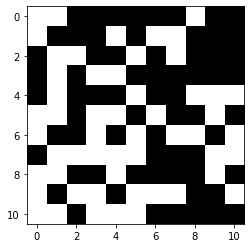

In [4]:
xi = random_patterns(N,p)
idx = np.random.randint(0,p)
J = R_coupling(xi,N,R)
#J = MF_coupling(xi,N)
print('Original pattern')
plt.imshow(xi[idx].reshape(L,L),cmap='Greys')

In [5]:
#new functions
#function for plot
def plot(x, y, sys):
    fig, ax = plt.subplots(1,3, figsize=(15,8))
    ax[0].set_title('Original pattern')
    ax[0].imshow(x.reshape(L,L),cmap='Greys')
    ax[1].set_title('Corrupted pattern')
    ax[1].imshow(y.reshape(L,L),cmap='Greys')
    ax[2].set_title('Recovered pattern')
    ax[2].imshow(sys.reshape(L,L),cmap='Greys')
    plt.show()

#running the algorithm
def algorithm(xi, idx, yi):
    sys = deterministic_hopfield(yi,30)

    wrong_pixels = error_im(xi[idx],sys)
    assigned_pattern = assign_pattern(xi,sys)
    
    return wrong_pixels, assigned_pattern, sys



## Uniform noise

First of all, we are going to analyse the uniform noise.
In this case, a certain $q$ is set as threshold probability. In order to corrupt the original pattern, a random number $r$ is generated with \textit{uniform distribution} for each pixel. If the value of $r$ is less than the threshold, that pixel is flipped. 

After the corruption the deterministic Hopfield function is applied in order to produce a \textit{Recovered Pattern}. The error with respect to the original pattern is also calculated. 


The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


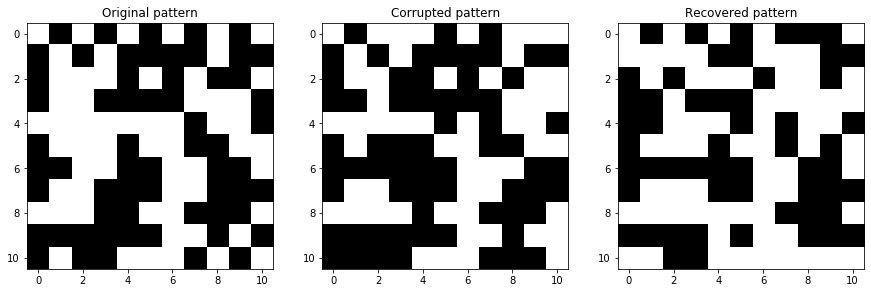

In [6]:
#creating corrupted random data thus corrupting xi
def corrupt_uniform(sys, q): # q probability to flip the pixel
    sys_temp = deepcopy(sys)
    N = sys.shape[0]
    for i in range(N):
        r = np.random.rand()
        if r < q:
            sys_temp[i] *= -1
    return sys_temp
    
idx = 1
yi = corrupt_uniform(xi[idx],0.1)
wrong_pixels, assigned_pattern, sys =algorithm(xi, idx, yi)
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))
plot(xi[idx], yi, sys)

## Gaussian noise

The gaussian distribution is given by:
$$
\\
g(x) = h \cdot \exp{\left[{-\frac{(x-\mu)^2}{2\sigma}}\right]}
\\
$$
where $h$ is the maximum height of the distribution, $\mu$ is its average and $\sigma$ its variance.

We overlapped a 2-dimensional gaussian to the original pattern, made by multiplycation of two statistically indipendent gaussians, in order to have a variable threshold and not a fixed one (like we did previously). 

We chose as variance an arbitrary value, i.e. $L/5$, such as to have an enough wide to be significant distribution, but also peaked enough. The coordinates of the centroids, instead, were chosen in order to pick only the most relevant cases: the center of the grid and its four corners.
Concerning the parameters $h$, it was decided not to chose the normalized version of the gaussian as it would have been unsignificant to our purpose, so we made it vary in a range between 0.1 and 1.

The generation of corrupted patterns worked exactly as explained above: a random number $r$ is generated with \textit{uniform distribution} for each pixel, if the value of $r$ is less than the threshold, set by the value of the gaussian in the considered point, that pixel is flipped. 

Again, after the corruption the deterministic Hopfield function is applied in order to produce a \textit{Recovered Pattern}. The error with respect to the original pattern is also calculated. 


In [7]:
def gaus(mu, sigma, h, x, y):
    h = np.sqrt(h)
    g_x = np.exp(-( (x-mu[0])**2 / ( 2.0 * sigma**2 ) ) )*h#/np.sqrt(2*np.pi*sigma**2)
    g_y = np.exp(-( (y-mu[1])**2 / ( 2.0 * sigma**2 ) ) )*h#/np.sqrt(2*np.pi*sigma**2)
    g = g_y * g_x
    return g
#mu is a 2d array representing the position of the centroid
#h is the maximum height of the gaussian

The position of the centroid is  [0 0] 

The height of the distribution is  0.1
The error of the algorithm is 0.314050
The algorithm recognised the pattern 8 and the correct pattern is 1


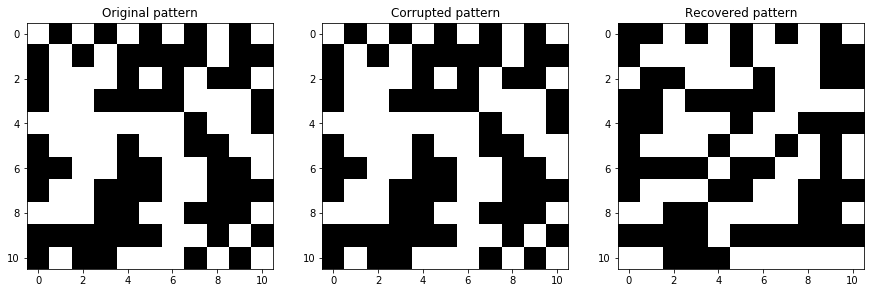

The height of the distribution is  0.2
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


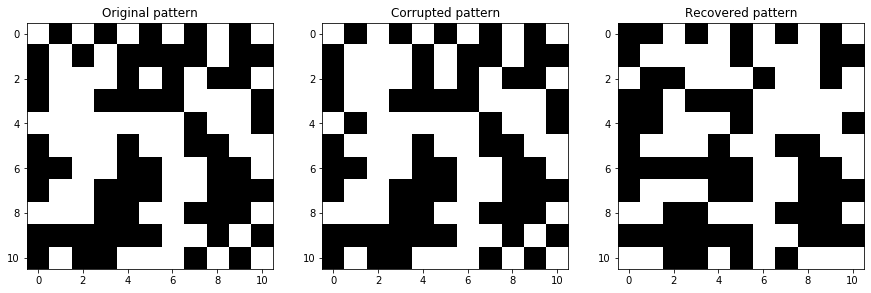

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


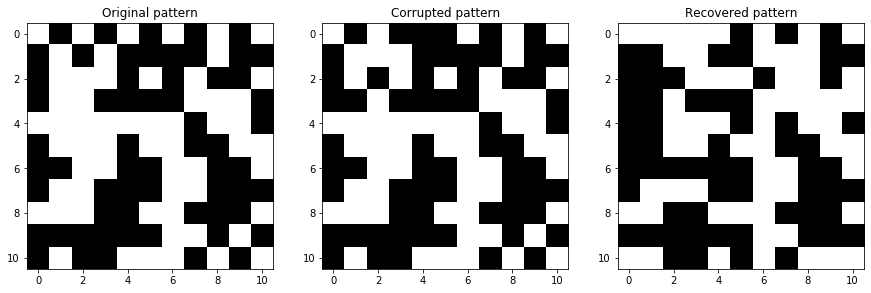

The height of the distribution is  0.4
The error of the algorithm is 0.190083
The algorithm recognised the pattern 1 and the correct pattern is 1


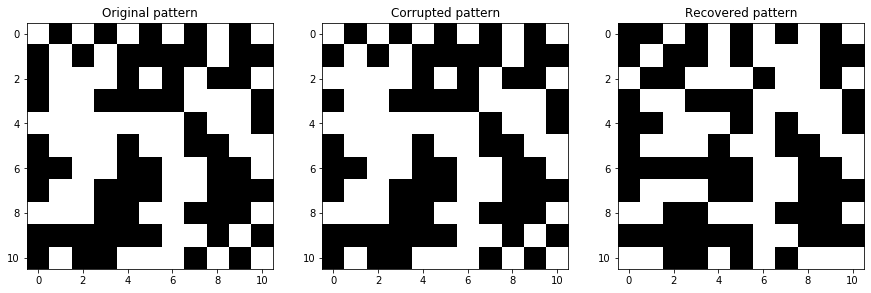

The height of the distribution is  0.5
The error of the algorithm is 0.198347
The algorithm recognised the pattern 1 and the correct pattern is 1


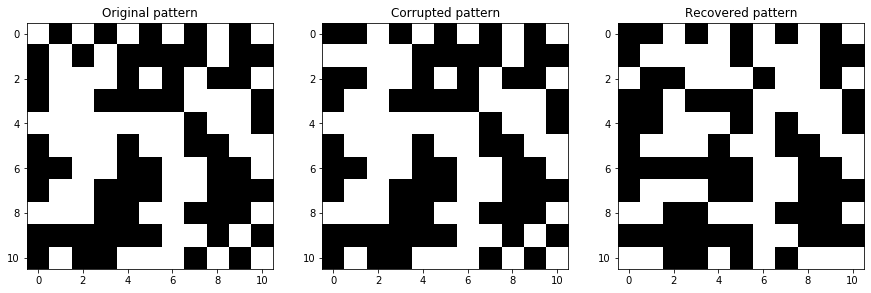

The height of the distribution is  0.6
The error of the algorithm is 0.239669
The algorithm recognised the pattern 1 and the correct pattern is 1


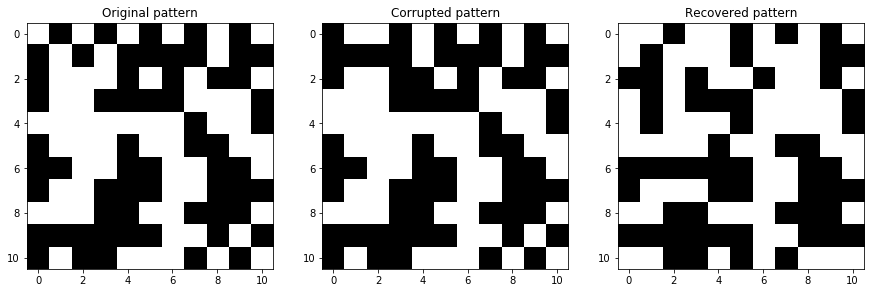

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.338843
The algorithm recognised the pattern 4 and the correct pattern is 1


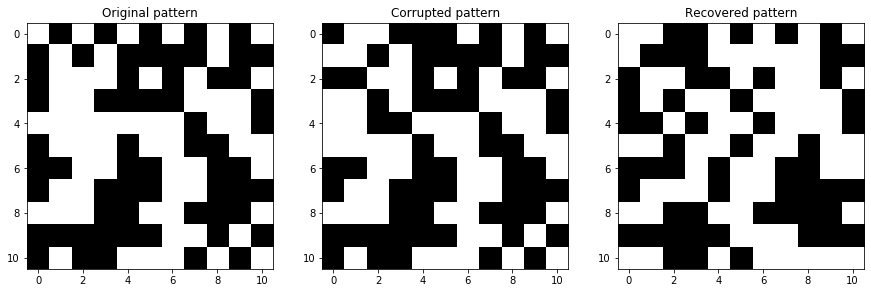

The height of the distribution is  0.8
The error of the algorithm is 0.314050
The algorithm recognised the pattern 1 and the correct pattern is 1


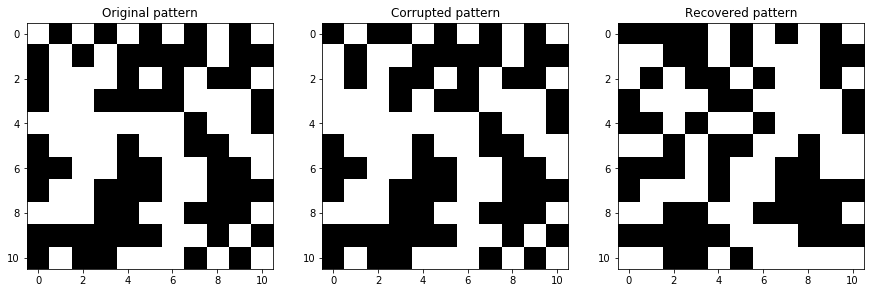

The height of the distribution is  0.9
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


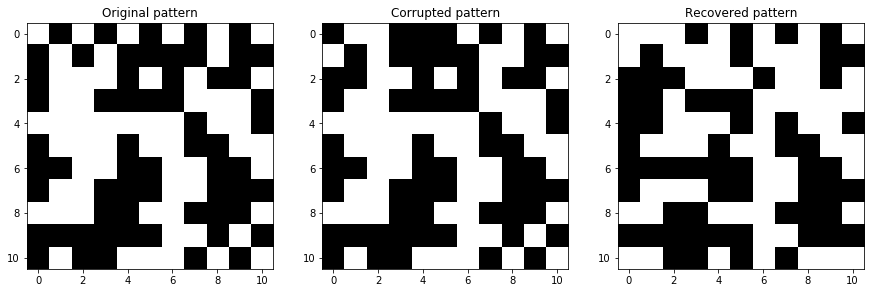

The height of the distribution is  1.0
The error of the algorithm is 0.206612
The algorithm recognised the pattern 1 and the correct pattern is 1


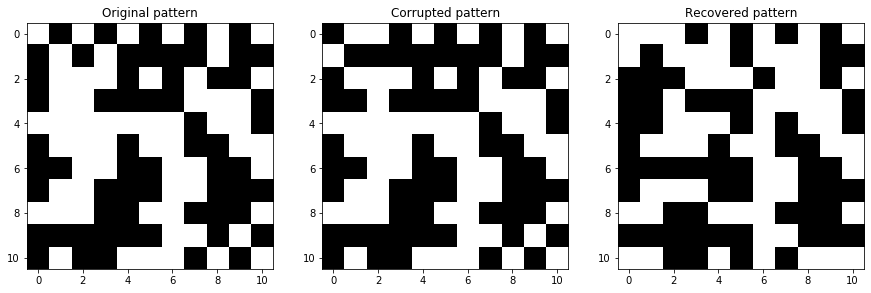

The position of the centroid is  [ 0 10] 

The height of the distribution is  0.1
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


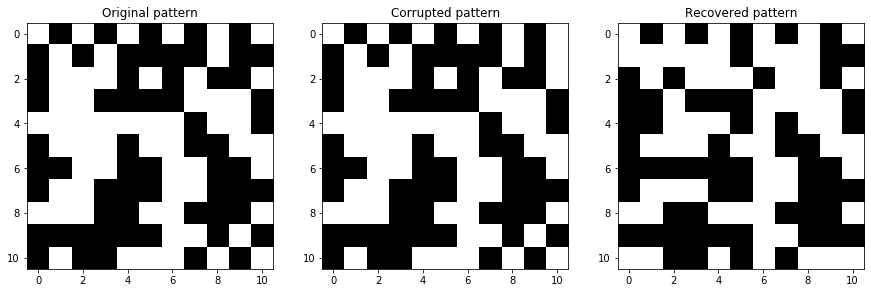

The height of the distribution is  0.2
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


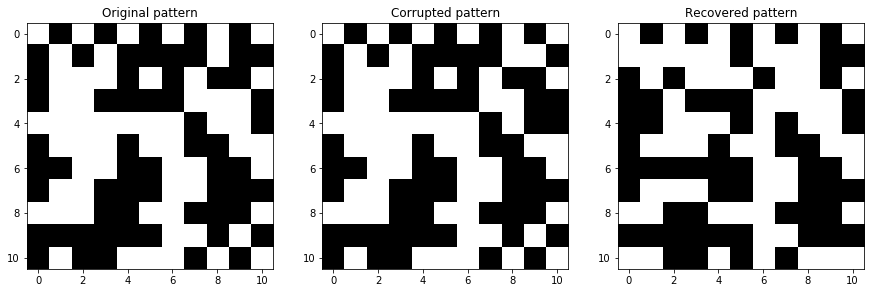

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


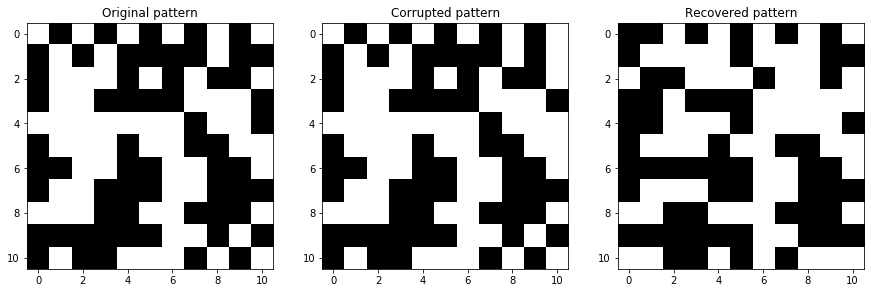

The height of the distribution is  0.4
The error of the algorithm is 0.206612
The algorithm recognised the pattern 1 and the correct pattern is 1


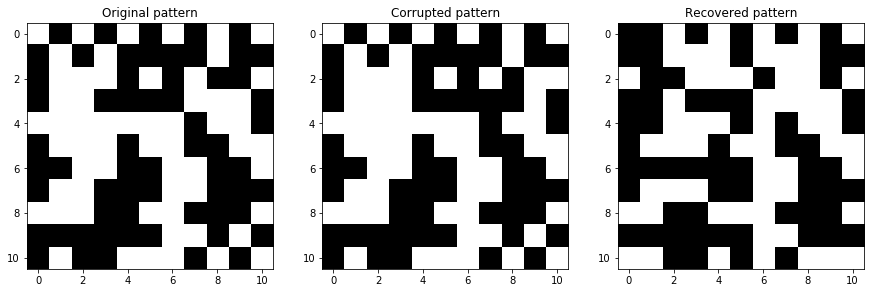

The height of the distribution is  0.5
The error of the algorithm is 0.206612
The algorithm recognised the pattern 1 and the correct pattern is 1


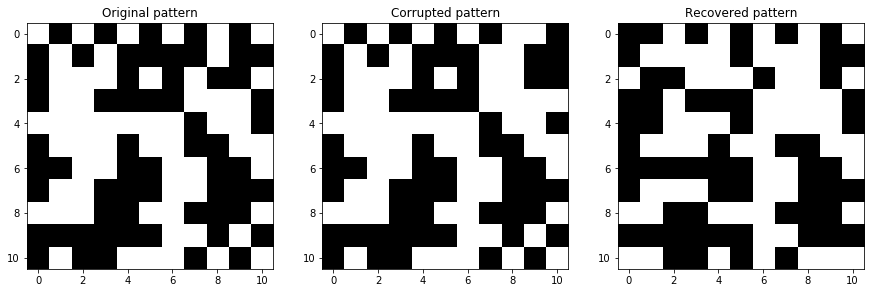

The height of the distribution is  0.6
The error of the algorithm is 0.198347
The algorithm recognised the pattern 1 and the correct pattern is 1


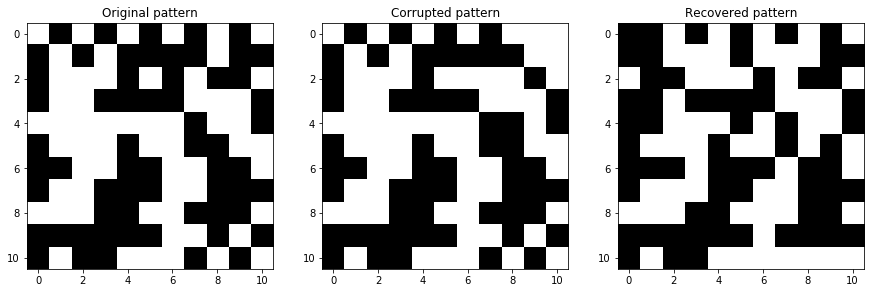

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.223140
The algorithm recognised the pattern 1 and the correct pattern is 1


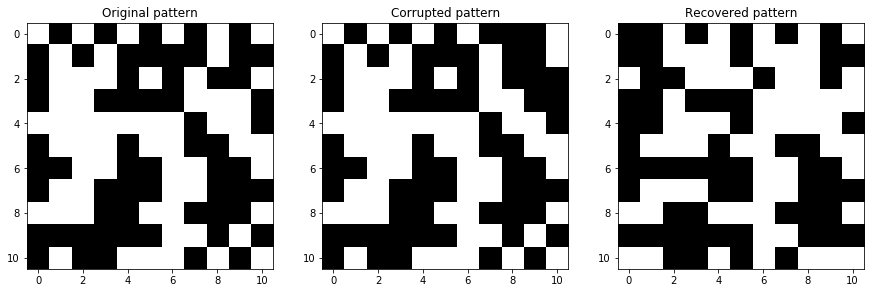

The height of the distribution is  0.8
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


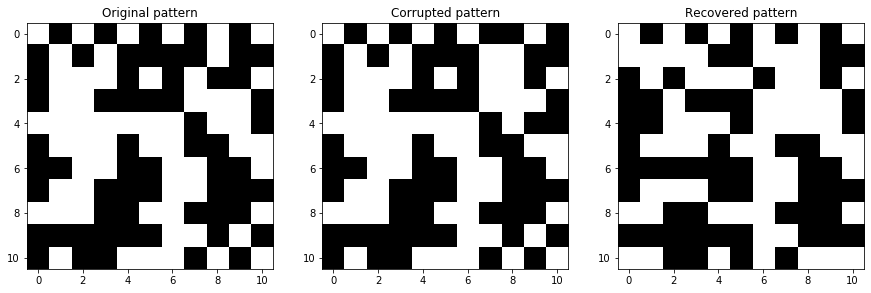

The height of the distribution is  0.9
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


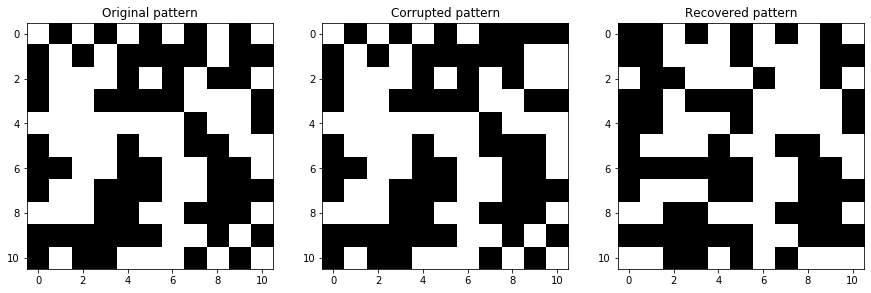

The height of the distribution is  1.0
The error of the algorithm is 0.247934
The algorithm recognised the pattern 1 and the correct pattern is 1


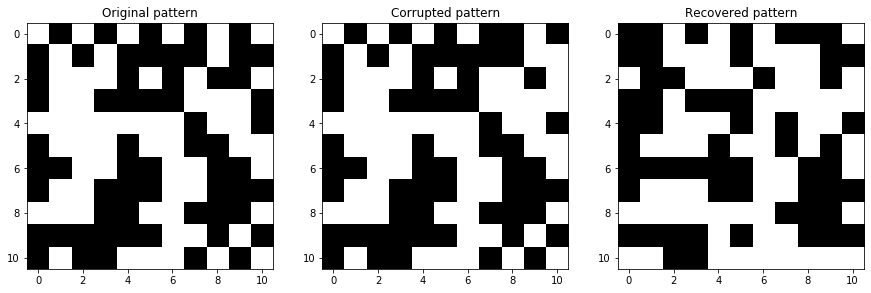

The position of the centroid is  [10  0] 

The height of the distribution is  0.1
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


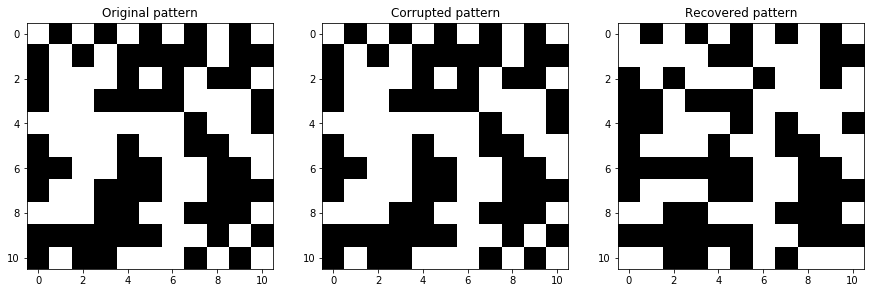

The height of the distribution is  0.2
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


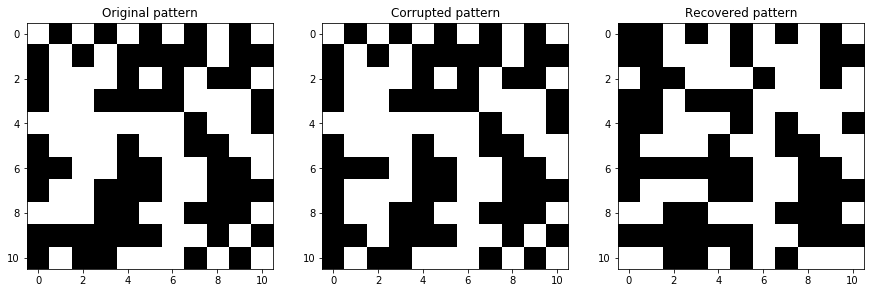

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


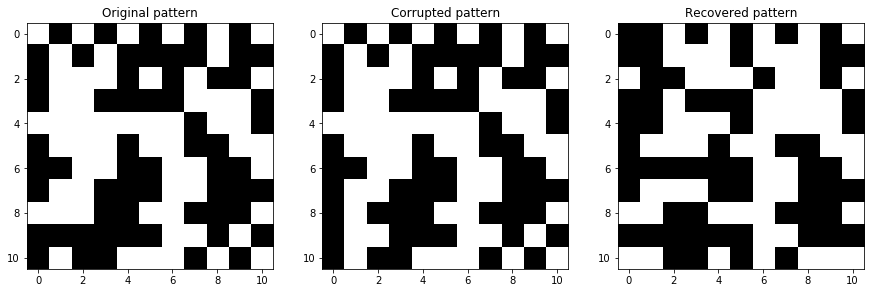

The height of the distribution is  0.4
The error of the algorithm is 0.330579
The algorithm recognised the pattern 8 and the correct pattern is 1


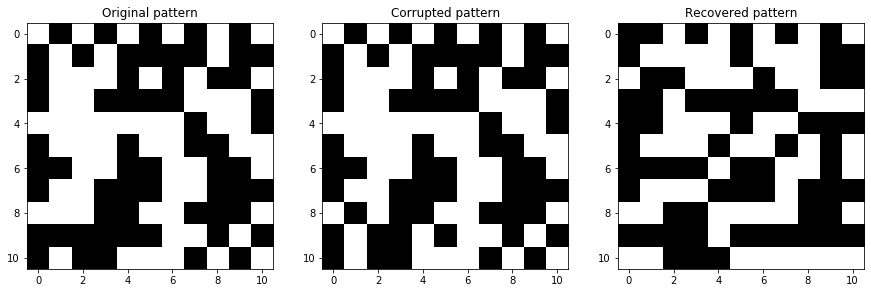

The height of the distribution is  0.5
The error of the algorithm is 0.421488
The algorithm recognised the pattern 8 and the correct pattern is 1


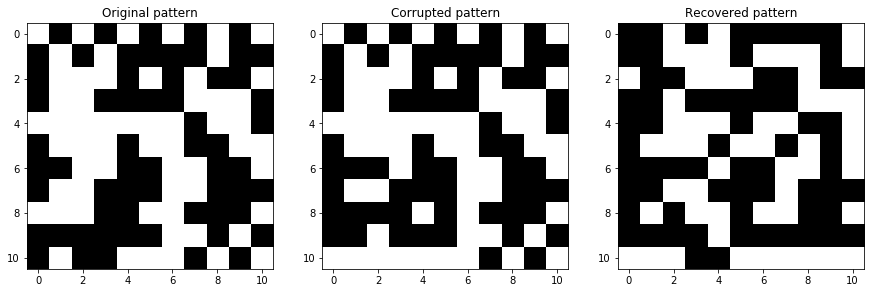

The height of the distribution is  0.6
The error of the algorithm is 0.322314
The algorithm recognised the pattern 8 and the correct pattern is 1


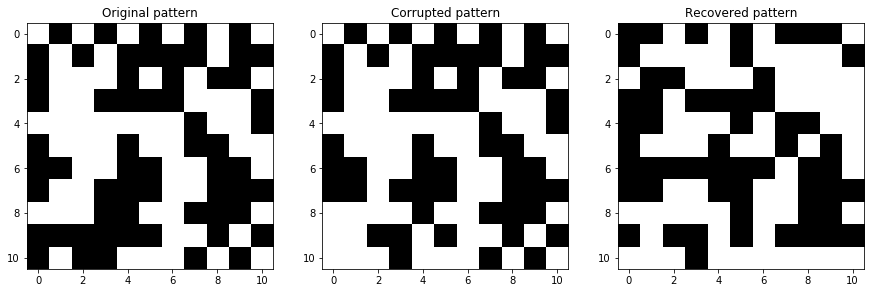

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.206612
The algorithm recognised the pattern 1 and the correct pattern is 1


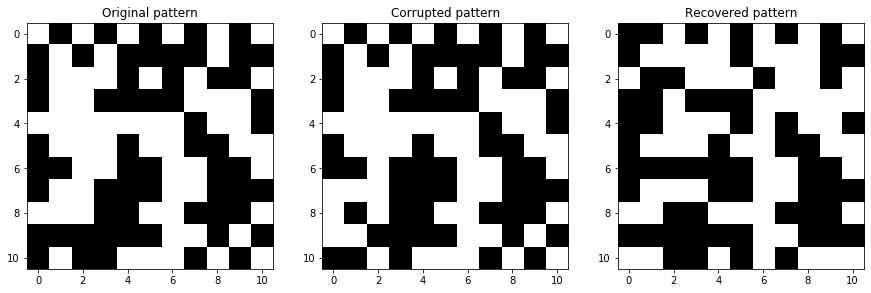

The height of the distribution is  0.8
The error of the algorithm is 0.206612
The algorithm recognised the pattern 1 and the correct pattern is 1


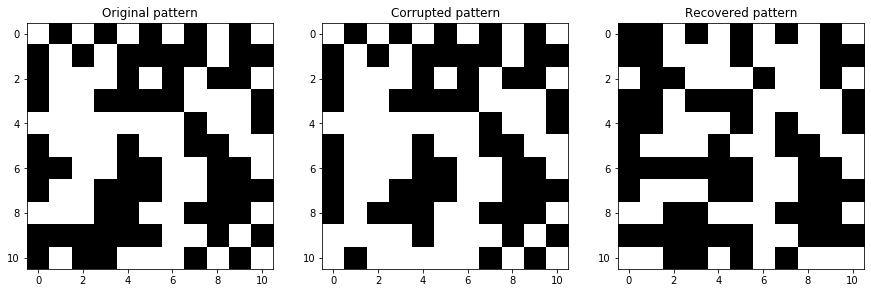

The height of the distribution is  0.9
The error of the algorithm is 0.396694
The algorithm recognised the pattern 2 and the correct pattern is 1


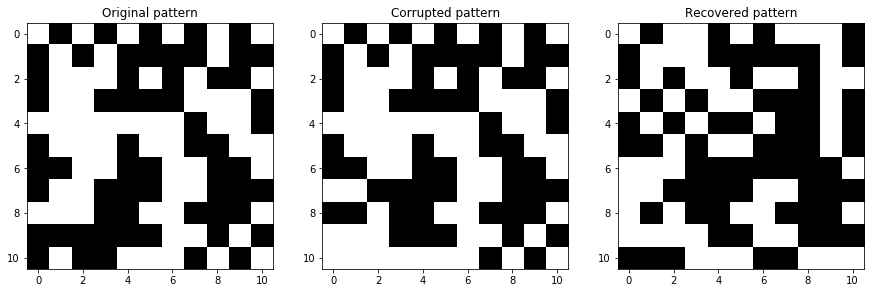

The height of the distribution is  1.0
The error of the algorithm is 0.173554
The algorithm recognised the pattern 1 and the correct pattern is 1


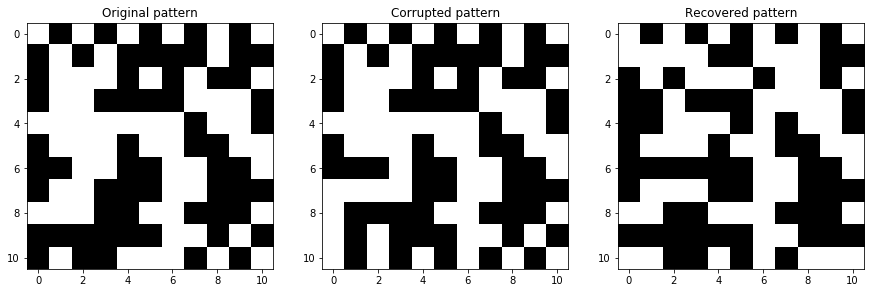

The position of the centroid is  [10 10] 

The height of the distribution is  0.1
The error of the algorithm is 0.338843
The algorithm recognised the pattern 8 and the correct pattern is 1


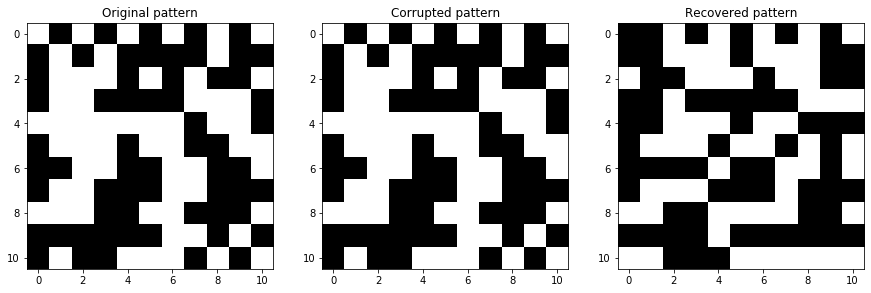

The height of the distribution is  0.2
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


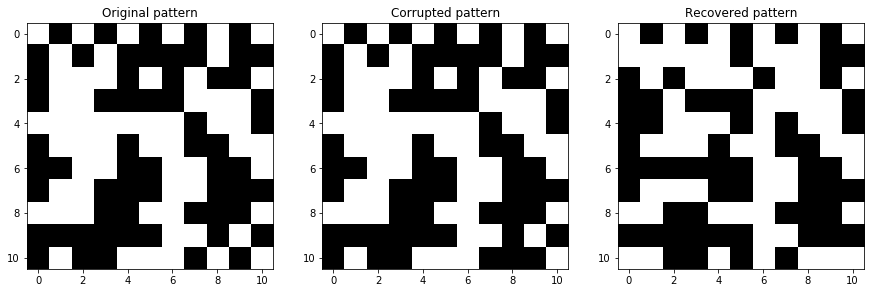

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.330579
The algorithm recognised the pattern 8 and the correct pattern is 1


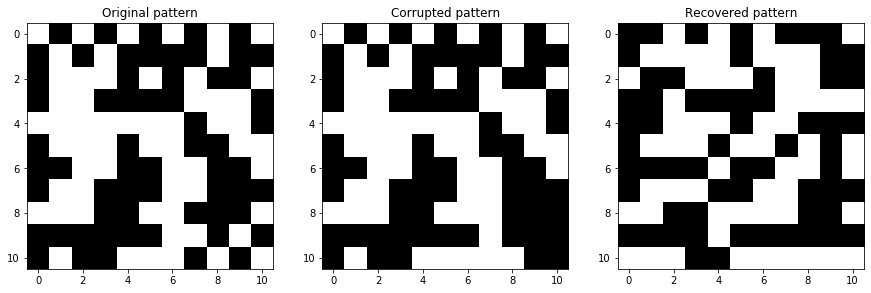

The height of the distribution is  0.4
The error of the algorithm is 0.322314
The algorithm recognised the pattern 8 and the correct pattern is 1


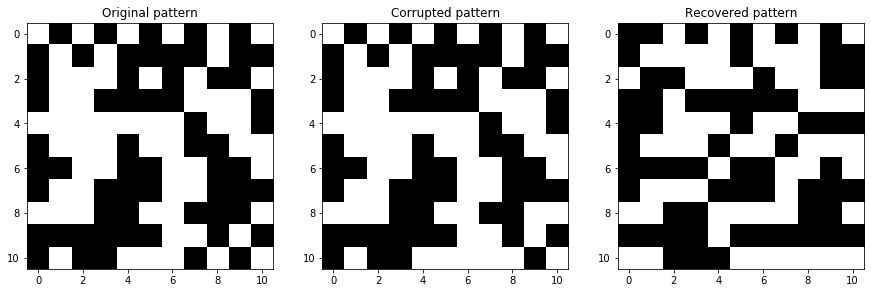

The height of the distribution is  0.5
The error of the algorithm is 0.388430
The algorithm recognised the pattern 4 and the correct pattern is 1


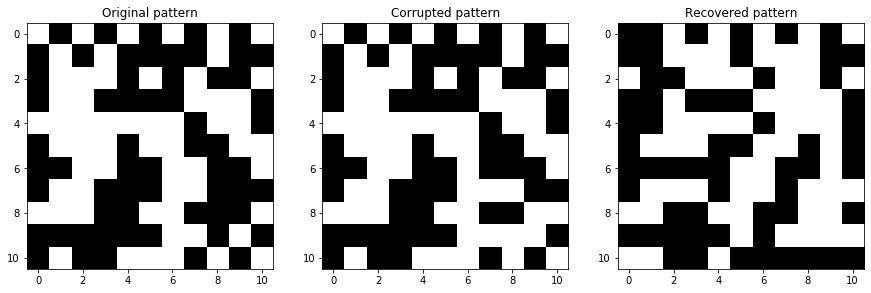

The height of the distribution is  0.6
The error of the algorithm is 0.355372
The algorithm recognised the pattern 4 and the correct pattern is 1


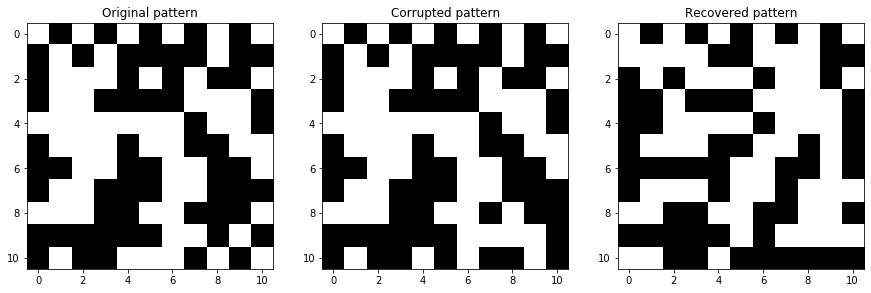

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.380165
The algorithm recognised the pattern 8 and the correct pattern is 1


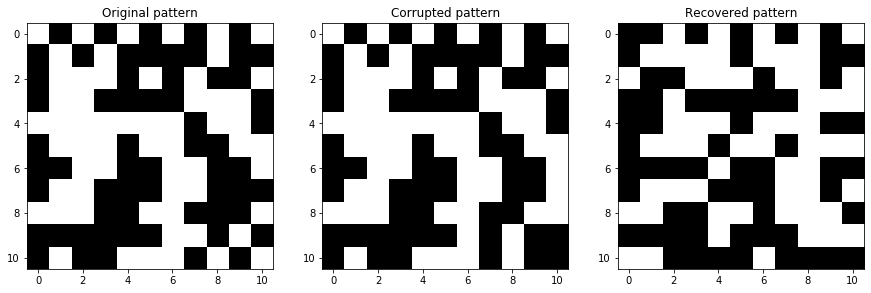

The height of the distribution is  0.8
The error of the algorithm is 0.314050
The algorithm recognised the pattern 8 and the correct pattern is 1


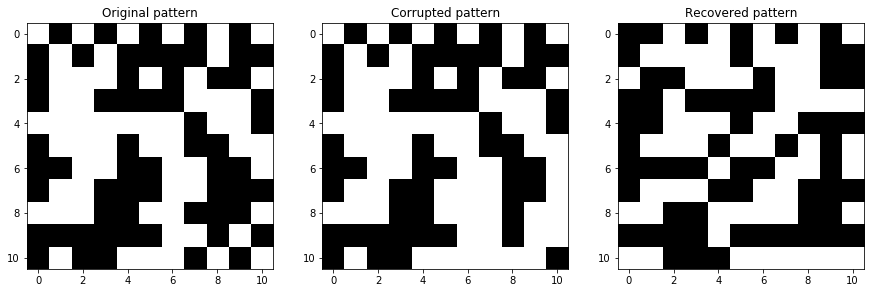

The height of the distribution is  0.9
The error of the algorithm is 0.330579
The algorithm recognised the pattern 4 and the correct pattern is 1


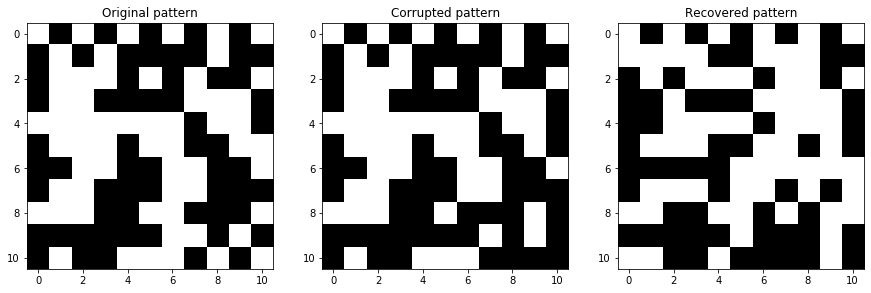

The height of the distribution is  1.0
The error of the algorithm is 0.247934
The algorithm recognised the pattern 1 and the correct pattern is 1


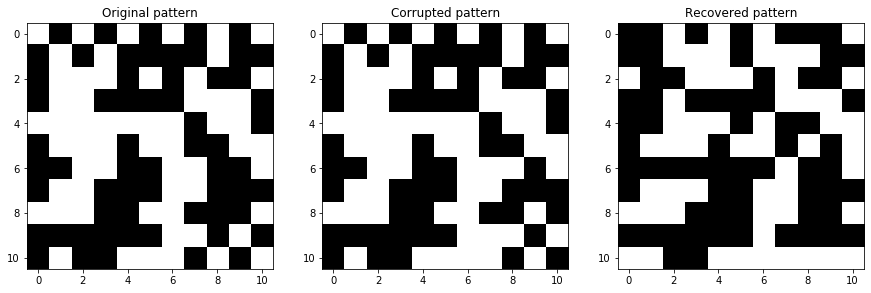

The position of the centroid is  [5 5] 

The height of the distribution is  0.1
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


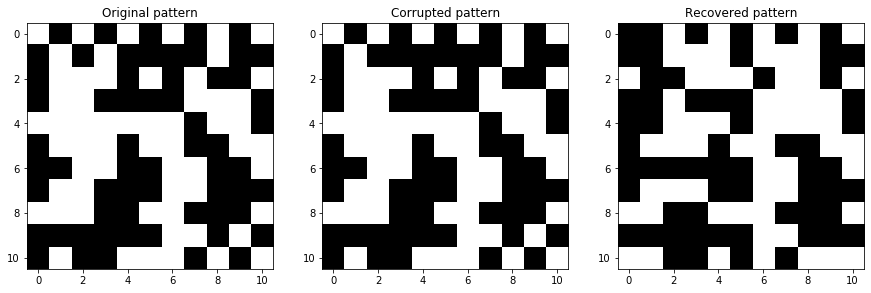

The height of the distribution is  0.2
The error of the algorithm is 0.256198
The algorithm recognised the pattern 1 and the correct pattern is 1


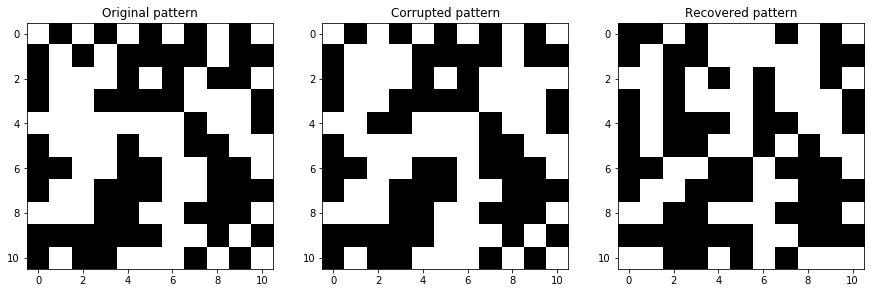

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.338843
The algorithm recognised the pattern 8 and the correct pattern is 1


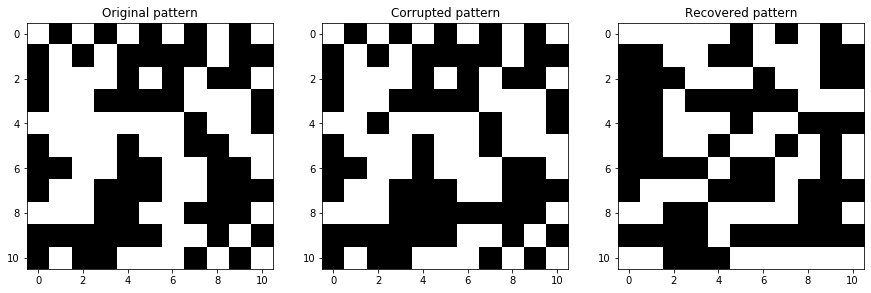

The height of the distribution is  0.4
The error of the algorithm is 0.256198
The algorithm recognised the pattern 1 and the correct pattern is 1


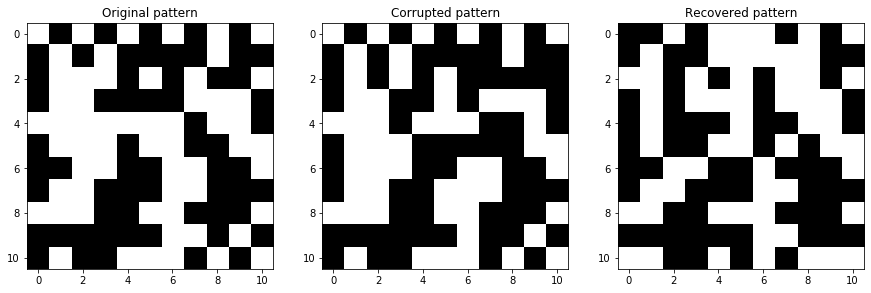

The height of the distribution is  0.5
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


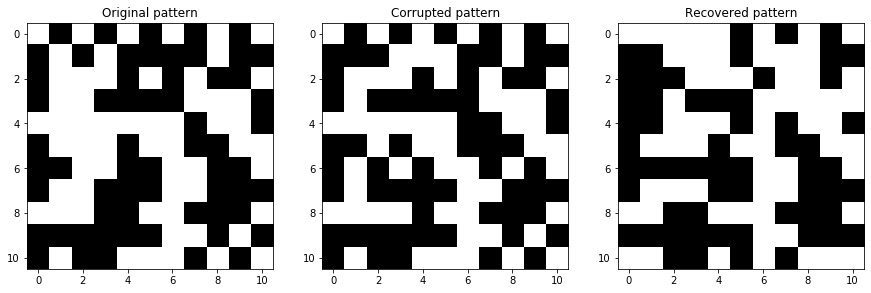

The height of the distribution is  0.6
The error of the algorithm is 0.239669
The algorithm recognised the pattern 1 and the correct pattern is 1


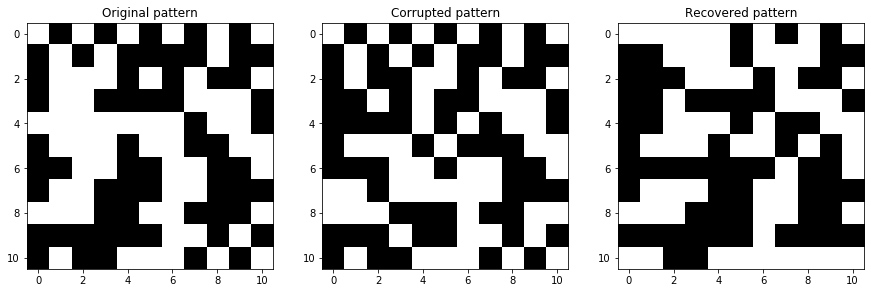

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.264463
The algorithm recognised the pattern 1 and the correct pattern is 1


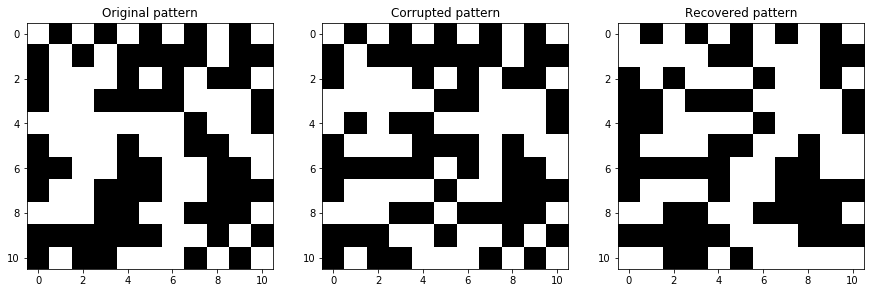

The height of the distribution is  0.8
The error of the algorithm is 0.272727
The algorithm recognised the pattern 1 and the correct pattern is 1


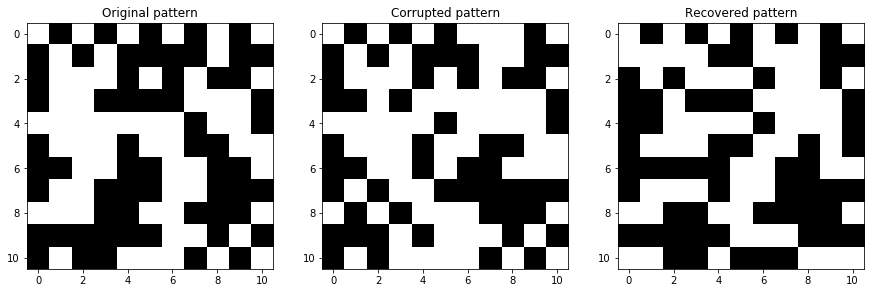

The height of the distribution is  0.9
The error of the algorithm is 0.289256
The algorithm recognised the pattern 1 and the correct pattern is 1


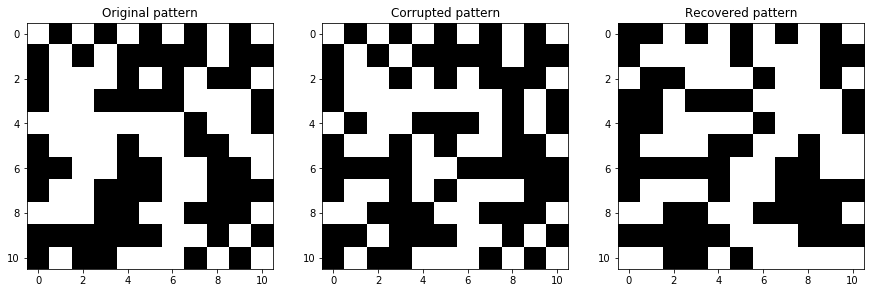

The height of the distribution is  1.0
The error of the algorithm is 0.363636
The algorithm recognised the pattern 0 and the correct pattern is 1


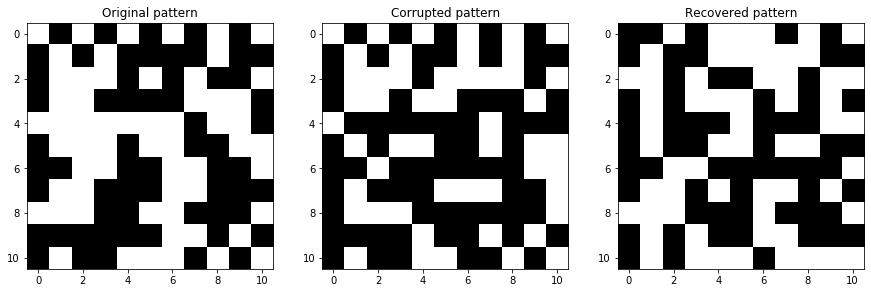

In [8]:
def corrupt_norm(sys, k, h):
    sys_temp = deepcopy(sys)
    sys_temp = sys_temp.reshape(L,L)
    N = sys.shape[0]
    for i in range(L):
        for j in range(L):
            g = gaus(k, L/5, h, i, j)
            r = np.random.rand()
            if r < g:
                sys_temp[i][j] *= -1
    return (sys_temp.reshape(1,N))[0]

idx = 1
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]
heights = np.linspace(0.1,1,10)

for k in centroids:
    print('The position of the centroid is ', k,'\n')
    for h in heights:
        print('The height of the distribution is ', h)
        yi = corrupt_norm(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        print('The error of the algorithm is %f' %(wrong_pixels))
        print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))
        plot(xi[idx], yi, sys)

## Cauchy noise

The Cauchy distribution is given by:
$$
\\
\mathcal{C}(x) = h \cdot \left(1 + \left(\frac{x- x_0}{\gamma}\right)^2 \right)^{-1}
\\
$$
where $h$ is the maximum height of the distribution, where $x_{0}$ is the location parameter, specifying the location of the peak of the distribution, and $\gamma$ is the scale parameter which specifies the half-width at half-maximum (HWHM).

We chose $\gamma$ in an arbitrary way as before, ($\gamma = L/5$) and made the peak $x_0$ of the distribution and its height $h$ change just like before.

We followed the same approach we used for the gaussian noise: we overlapped a 2-dimensional Cauchy distribution, and we used it to have a variable threshold. Then we generated corrupted patterns, recovered them and evaluated the error.


In [9]:
def cauchy(mu, gamma, h, x, y):
    h = np.sqrt(h)
    c_x = h/(1 + (((x-mu[0]))/gamma)**2)
    c_y = h/(1 + (((y-mu[1]))/gamma)**2)
    c = c_y * c_x
    return c
#mu is a 2d array representing the position of the median
#h is the maximum height of the distribution

The position of the median is  [0 0] 

The height of the distribution is  0.1
The error of the algorithm is 0.322314
The algorithm recognised the pattern 8 and the correct pattern is 1


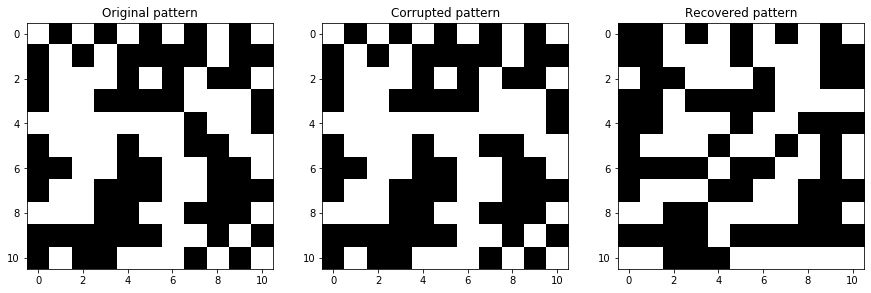

The height of the distribution is  0.2
The error of the algorithm is 0.198347
The algorithm recognised the pattern 1 and the correct pattern is 1


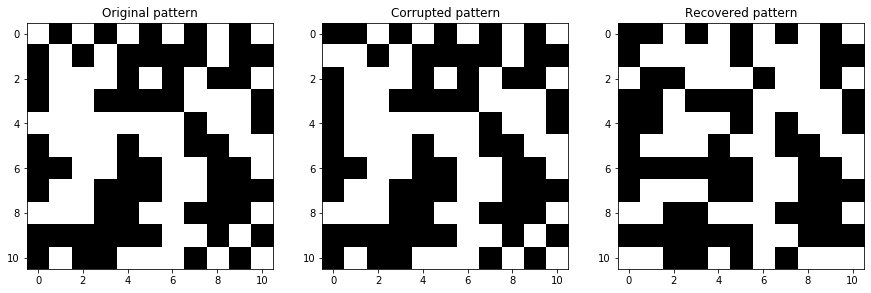

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.223140
The algorithm recognised the pattern 1 and the correct pattern is 1


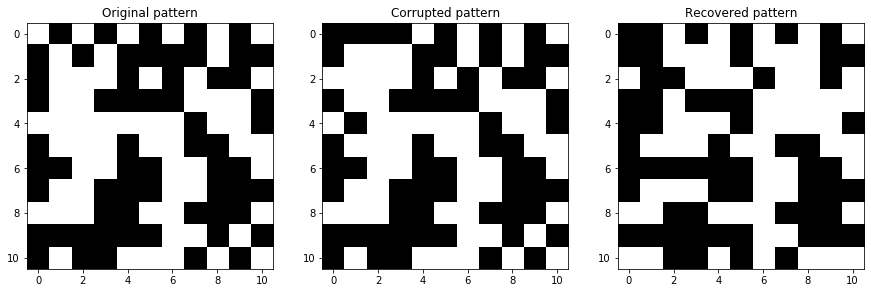

The height of the distribution is  0.4
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


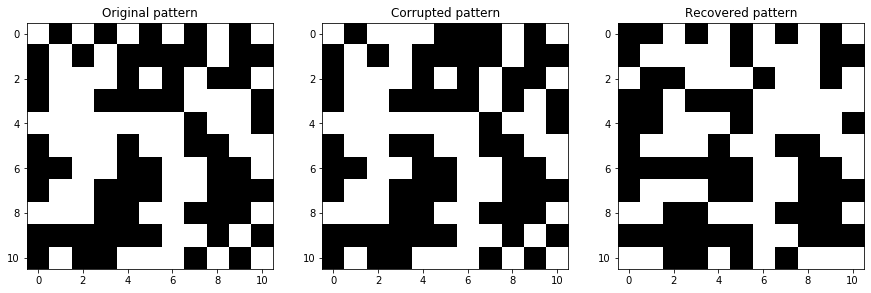

The height of the distribution is  0.5
The error of the algorithm is 0.280992
The algorithm recognised the pattern 1 and the correct pattern is 1


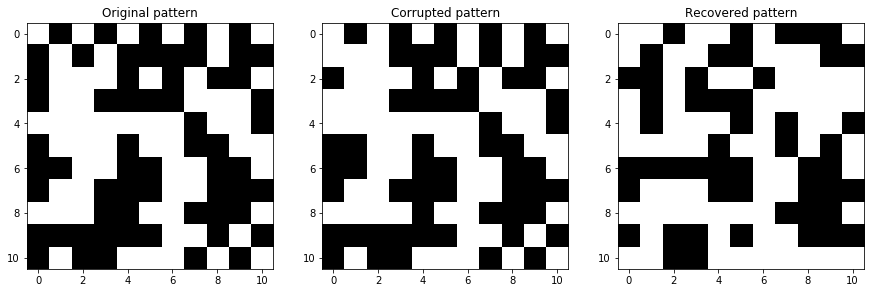

The height of the distribution is  0.6
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


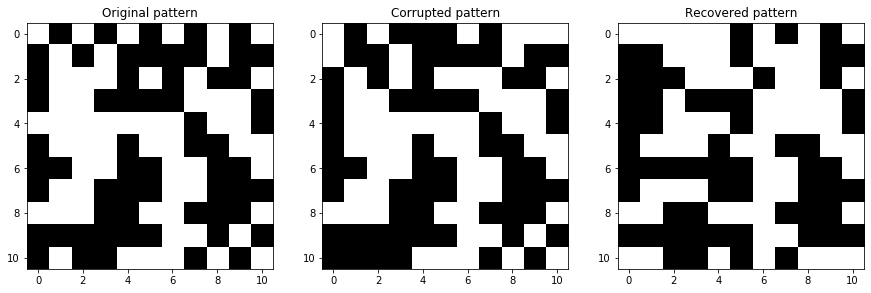

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


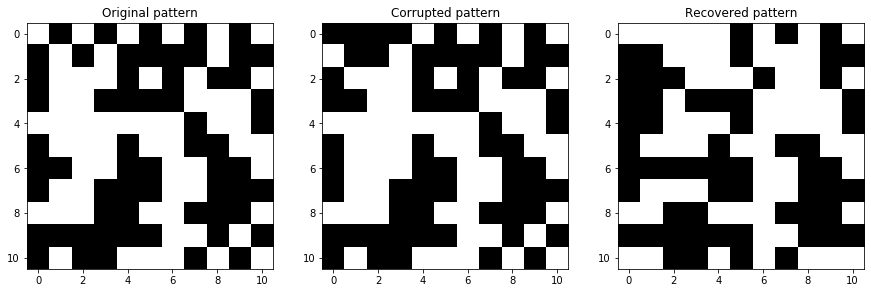

The height of the distribution is  0.8
The error of the algorithm is 0.190083
The algorithm recognised the pattern 1 and the correct pattern is 1


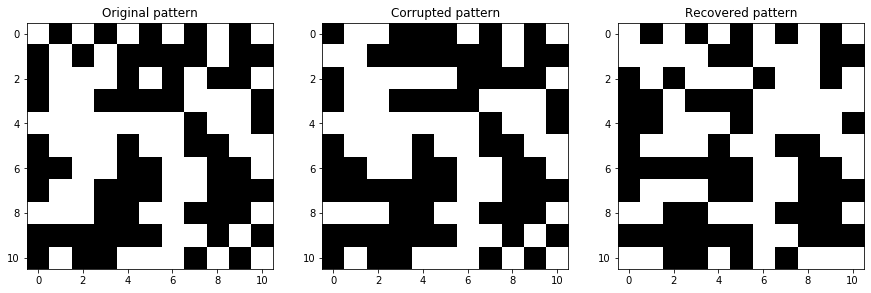

The height of the distribution is  0.9
The error of the algorithm is 0.198347
The algorithm recognised the pattern 1 and the correct pattern is 1


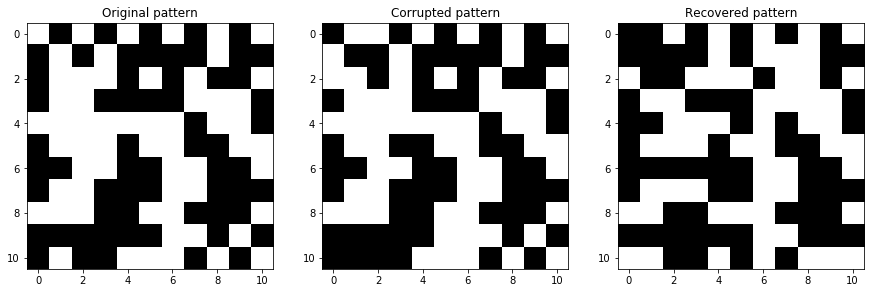

The height of the distribution is  1.0
The error of the algorithm is 0.330579
The algorithm recognised the pattern 1 and the correct pattern is 1


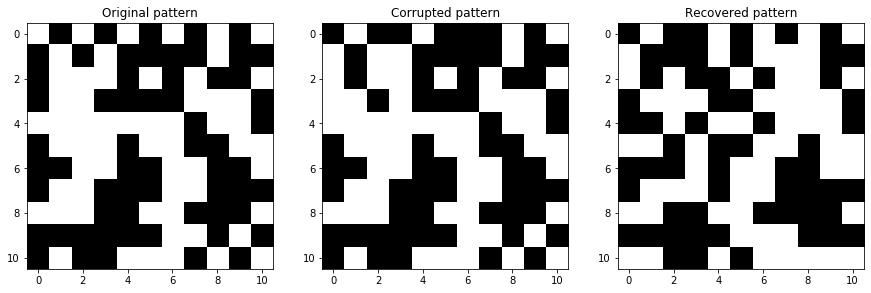

The position of the median is  [ 0 10] 

The height of the distribution is  0.1
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


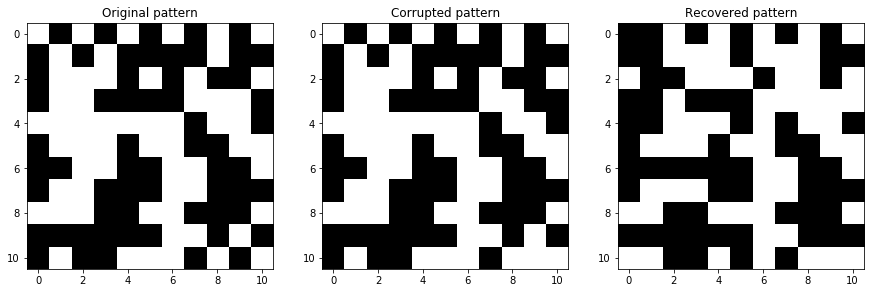

The height of the distribution is  0.2
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


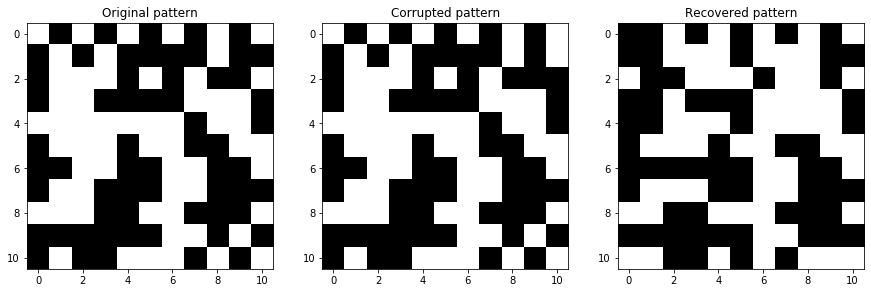

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.190083
The algorithm recognised the pattern 1 and the correct pattern is 1


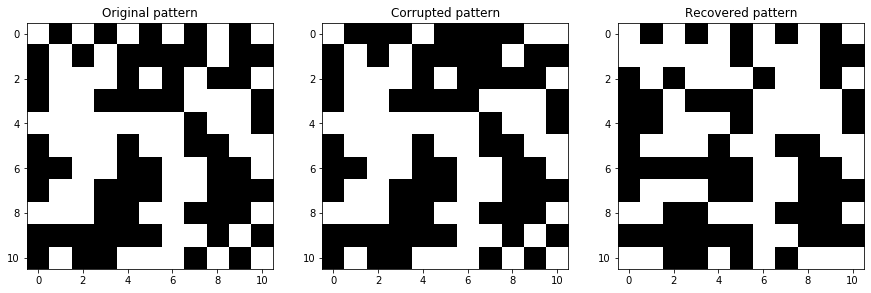

The height of the distribution is  0.4
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


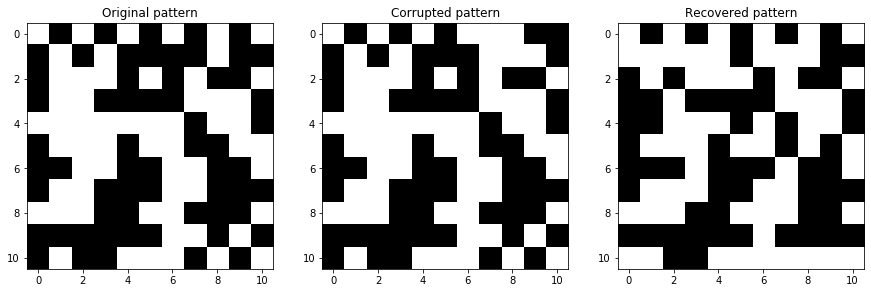

The height of the distribution is  0.5
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


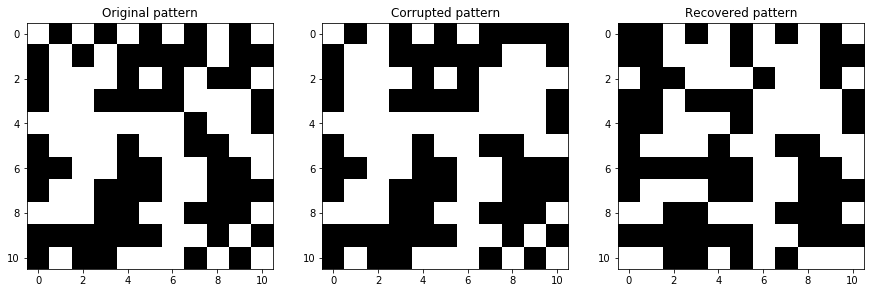

The height of the distribution is  0.6
The error of the algorithm is 0.198347
The algorithm recognised the pattern 1 and the correct pattern is 1


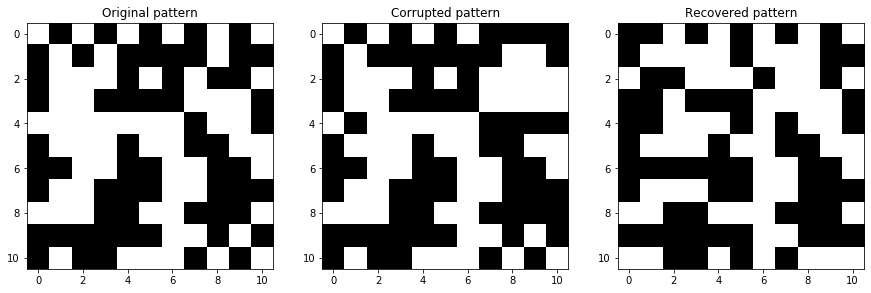

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.214876
The algorithm recognised the pattern 1 and the correct pattern is 1


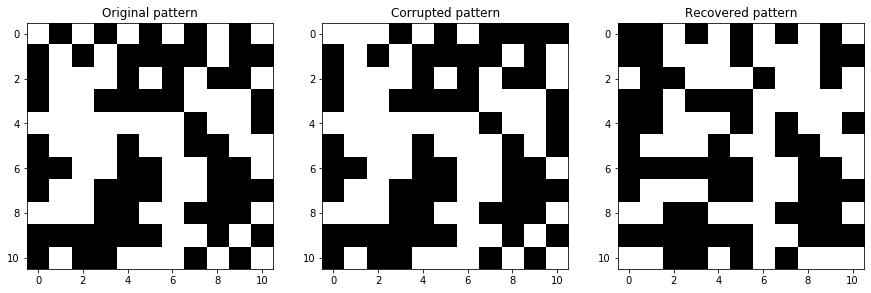

The height of the distribution is  0.8
The error of the algorithm is 0.305785
The algorithm recognised the pattern 1 and the correct pattern is 1


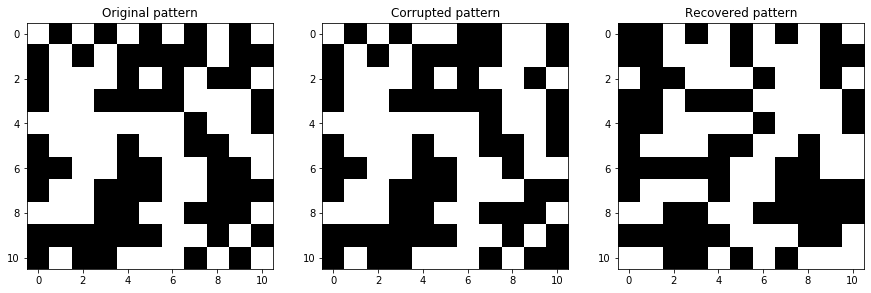

The height of the distribution is  0.9
The error of the algorithm is 0.322314
The algorithm recognised the pattern 8 and the correct pattern is 1


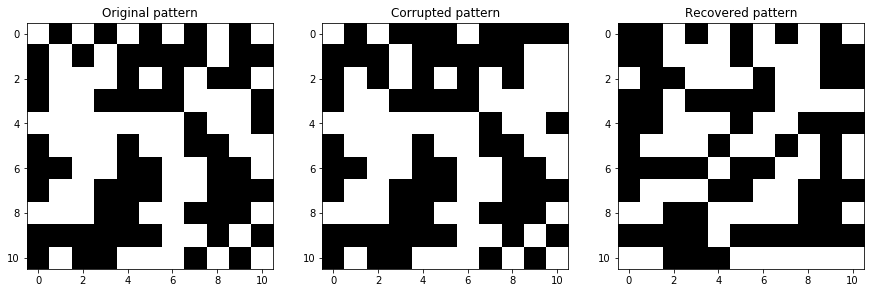

The height of the distribution is  1.0
The error of the algorithm is 0.223140
The algorithm recognised the pattern 1 and the correct pattern is 1


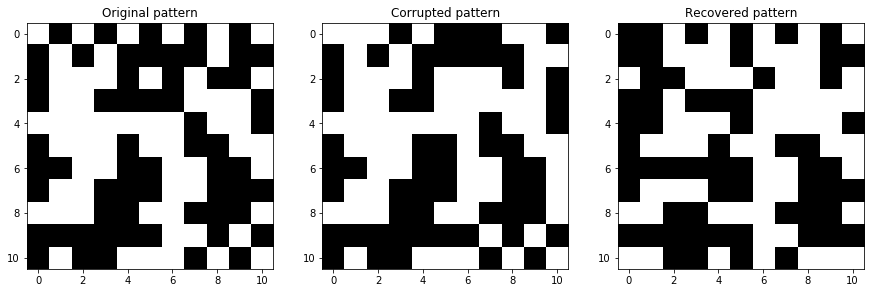

The position of the median is  [10  0] 

The height of the distribution is  0.1
The error of the algorithm is 0.223140
The algorithm recognised the pattern 1 and the correct pattern is 1


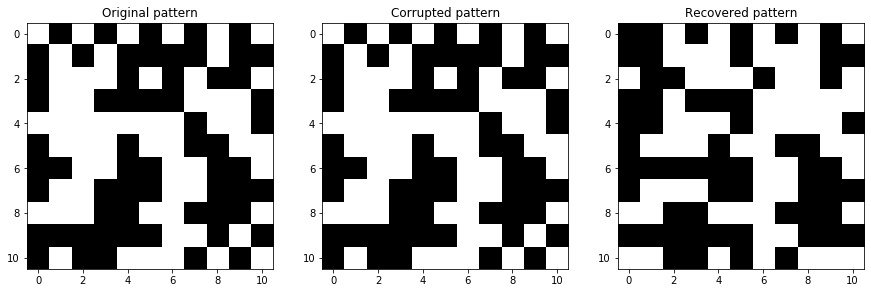

The height of the distribution is  0.2
The error of the algorithm is 0.198347
The algorithm recognised the pattern 1 and the correct pattern is 1


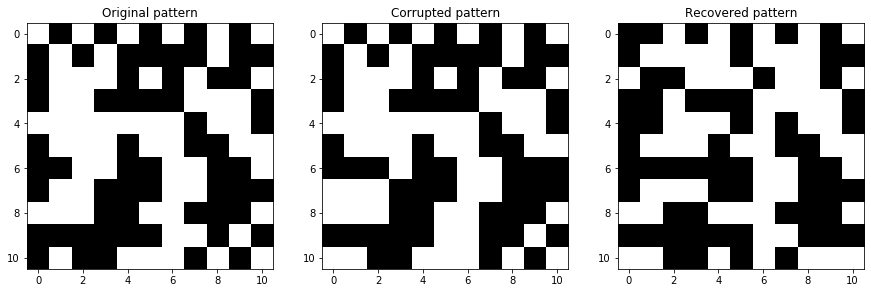

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.206612
The algorithm recognised the pattern 1 and the correct pattern is 1


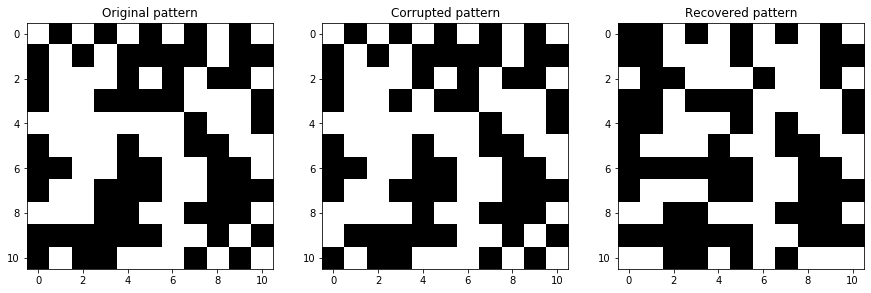

The height of the distribution is  0.4
The error of the algorithm is 0.198347
The algorithm recognised the pattern 1 and the correct pattern is 1


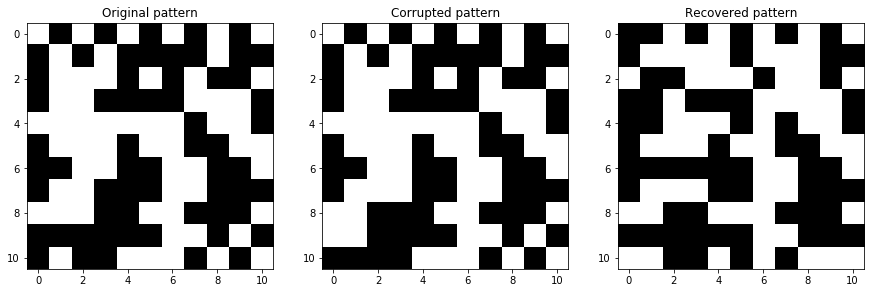

The height of the distribution is  0.5
The error of the algorithm is 0.206612
The algorithm recognised the pattern 1 and the correct pattern is 1


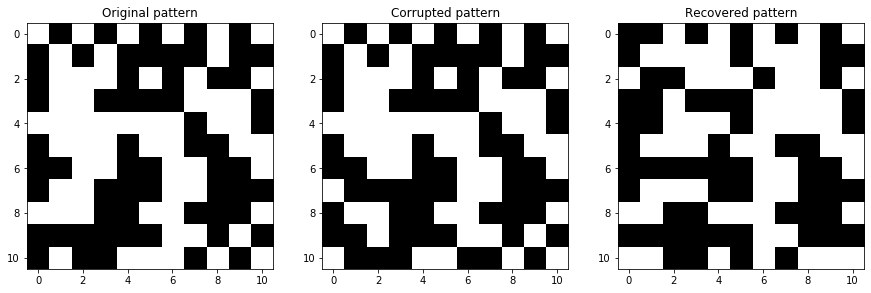

The height of the distribution is  0.6
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


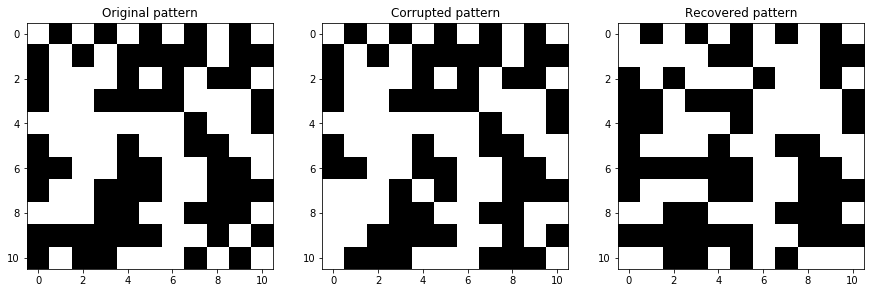

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


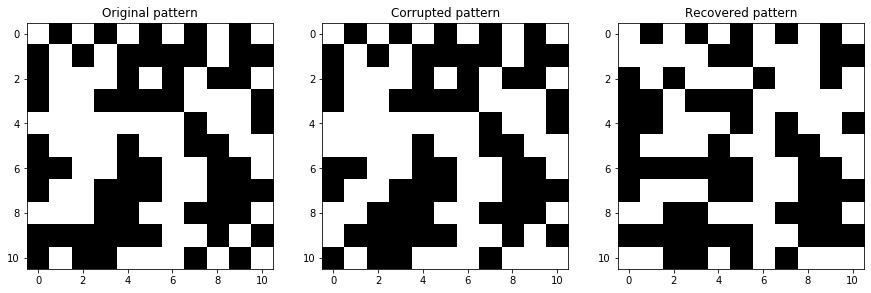

The height of the distribution is  0.8
The error of the algorithm is 0.264463
The algorithm recognised the pattern 1 and the correct pattern is 1


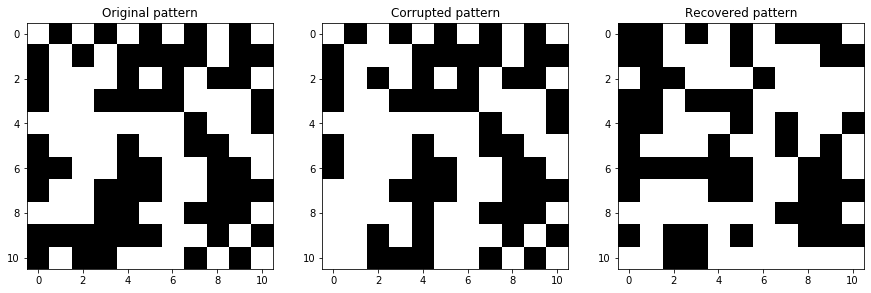

The height of the distribution is  0.9
The error of the algorithm is 0.223140
The algorithm recognised the pattern 1 and the correct pattern is 1


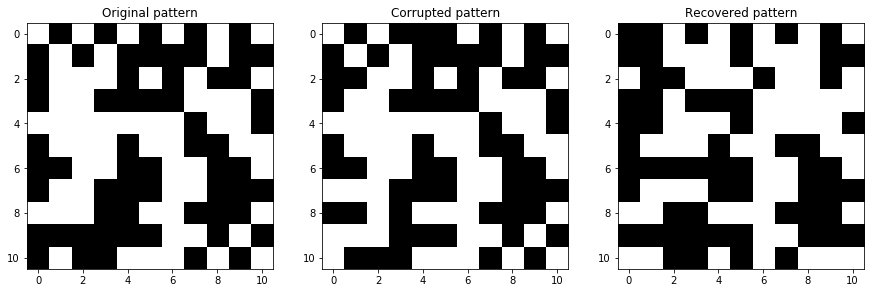

The height of the distribution is  1.0
The error of the algorithm is 0.198347
The algorithm recognised the pattern 1 and the correct pattern is 1


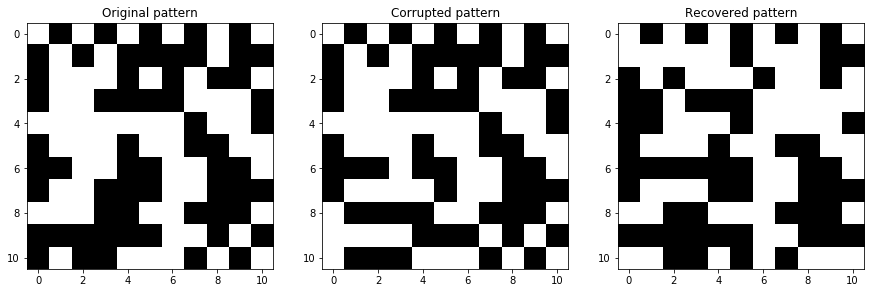

The position of the median is  [10 10] 

The height of the distribution is  0.1
The error of the algorithm is 0.206612
The algorithm recognised the pattern 1 and the correct pattern is 1


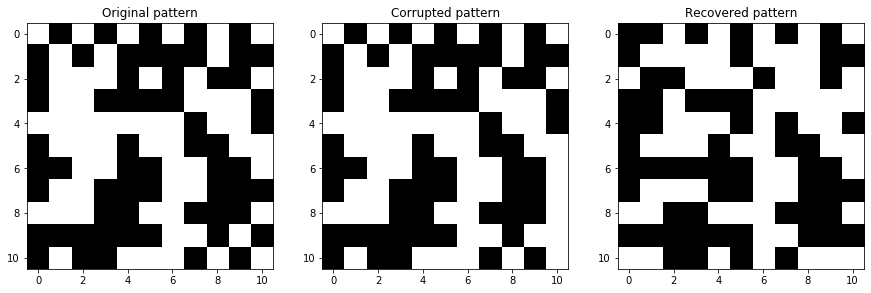

The height of the distribution is  0.2
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


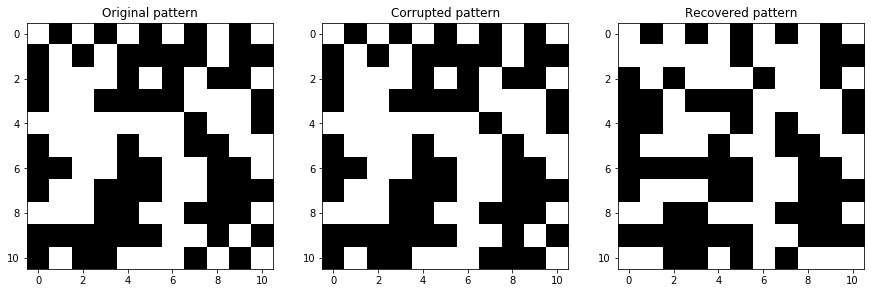

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.330579
The algorithm recognised the pattern 8 and the correct pattern is 1


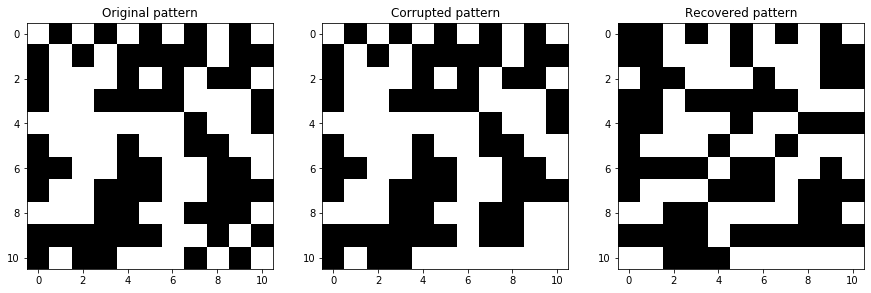

The height of the distribution is  0.4
The error of the algorithm is 0.231405
The algorithm recognised the pattern 1 and the correct pattern is 1


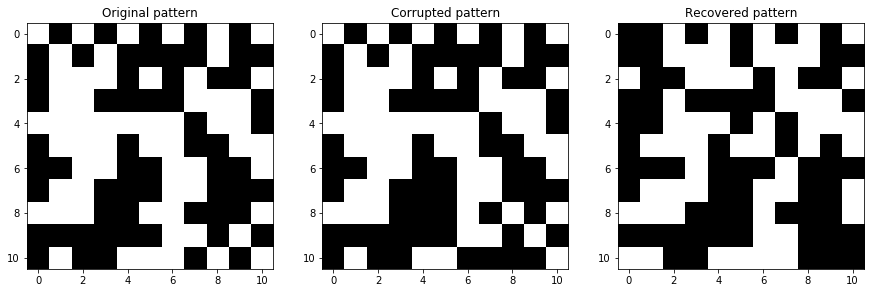

The height of the distribution is  0.5
The error of the algorithm is 0.272727
The algorithm recognised the pattern 1 and the correct pattern is 1


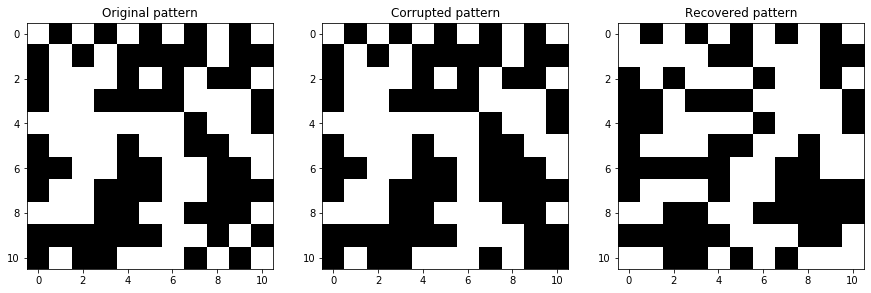

The height of the distribution is  0.6
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


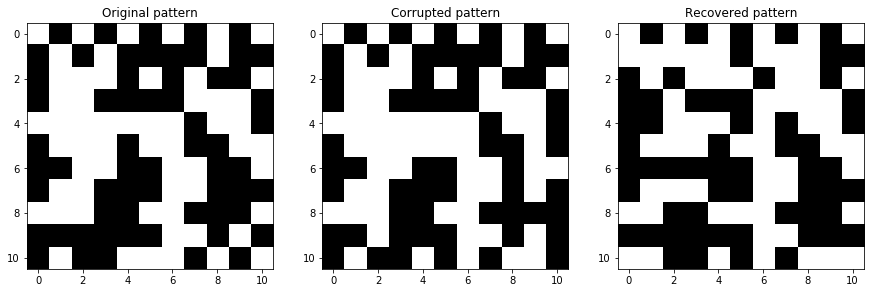

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.388430
The algorithm recognised the pattern 4 and the correct pattern is 1


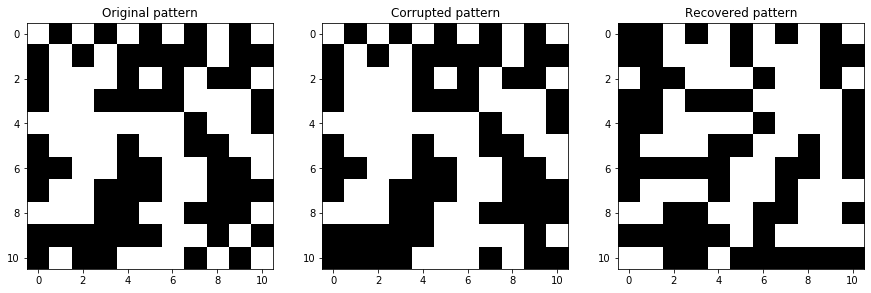

The height of the distribution is  0.8
The error of the algorithm is 0.190083
The algorithm recognised the pattern 1 and the correct pattern is 1


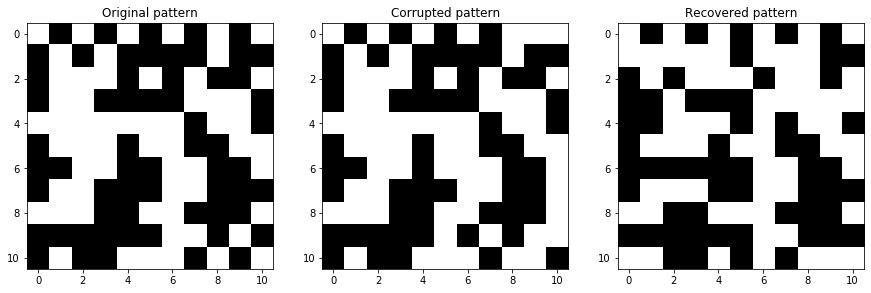

The height of the distribution is  0.9
The error of the algorithm is 0.190083
The algorithm recognised the pattern 1 and the correct pattern is 1


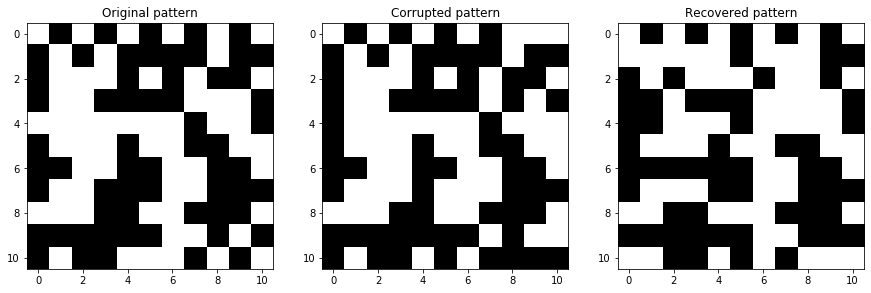

The height of the distribution is  1.0
The error of the algorithm is 0.338843
The algorithm recognised the pattern 8 and the correct pattern is 1


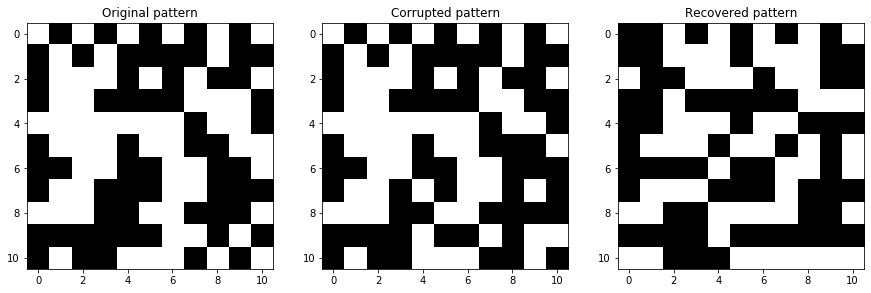

The position of the median is  [5 5] 

The height of the distribution is  0.1
The error of the algorithm is 0.173554
The algorithm recognised the pattern 1 and the correct pattern is 1


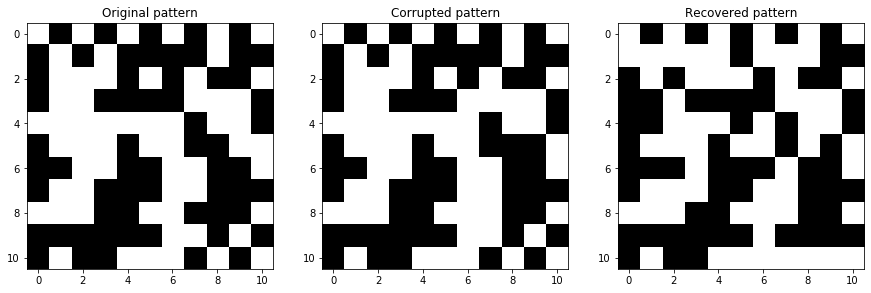

The height of the distribution is  0.2
The error of the algorithm is 0.181818
The algorithm recognised the pattern 1 and the correct pattern is 1


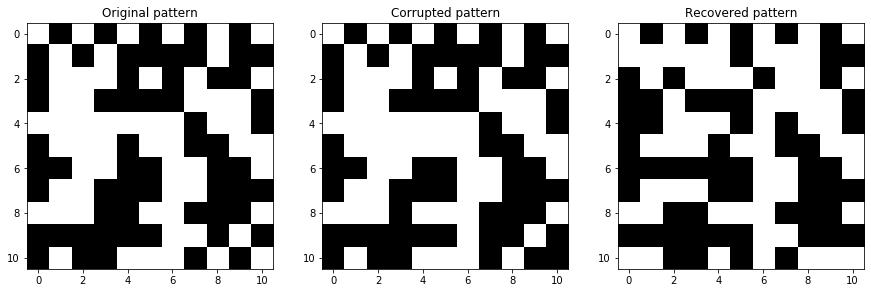

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.231405
The algorithm recognised the pattern 1 and the correct pattern is 1


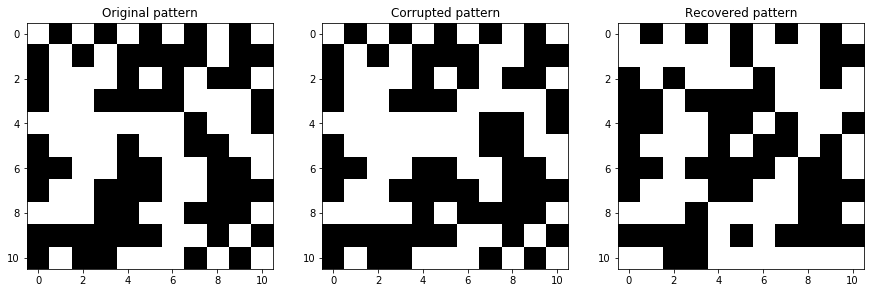

The height of the distribution is  0.4
The error of the algorithm is 0.206612
The algorithm recognised the pattern 1 and the correct pattern is 1


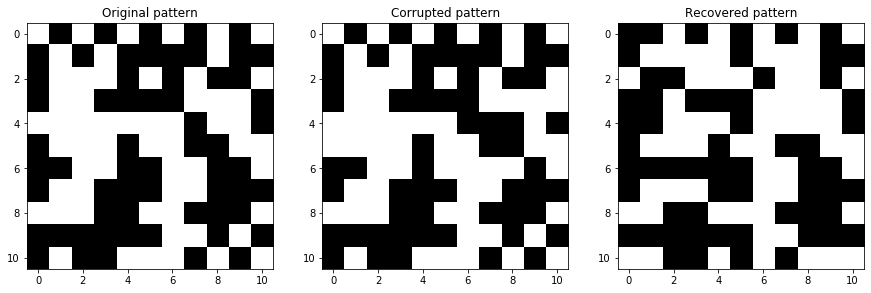

The height of the distribution is  0.5
The error of the algorithm is 0.206612
The algorithm recognised the pattern 1 and the correct pattern is 1


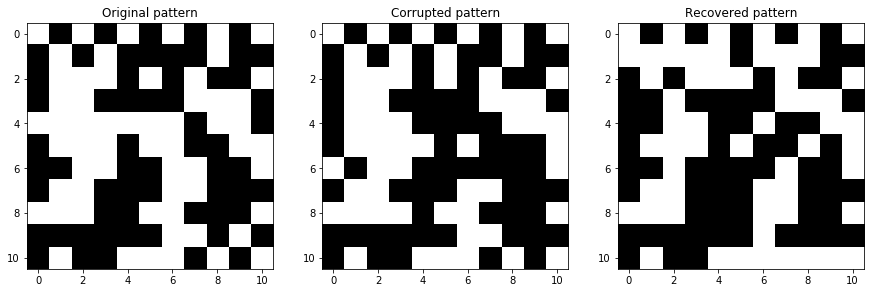

The height of the distribution is  0.6
The error of the algorithm is 0.297521
The algorithm recognised the pattern 1 and the correct pattern is 1


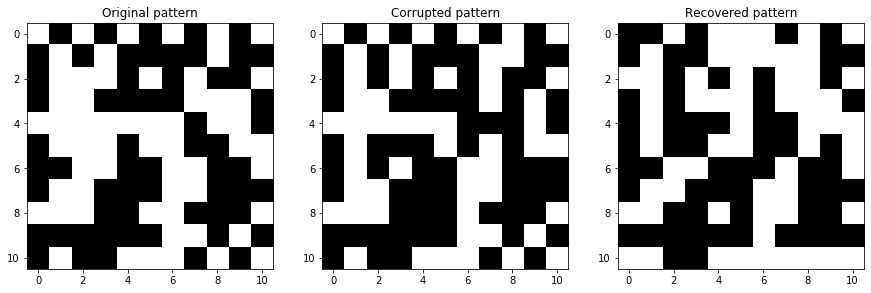

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.247934
The algorithm recognised the pattern 1 and the correct pattern is 1


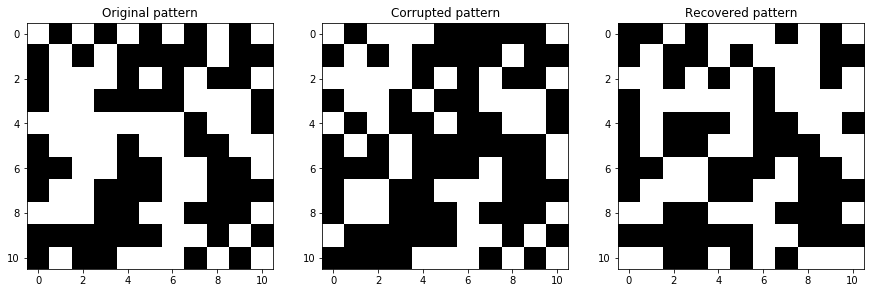

The height of the distribution is  0.8
The error of the algorithm is 0.322314
The algorithm recognised the pattern 8 and the correct pattern is 1


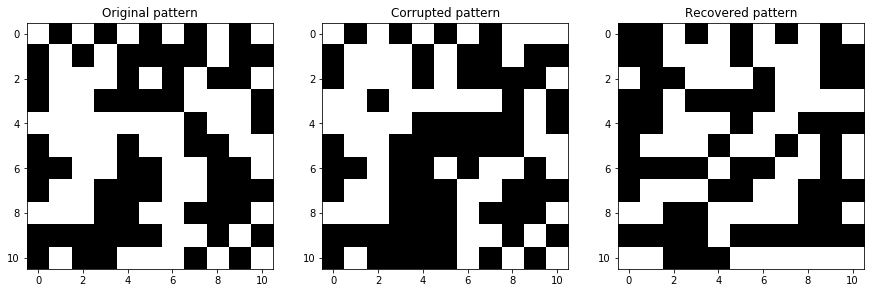

The height of the distribution is  0.9
The error of the algorithm is 0.305785
The algorithm recognised the pattern 8 and the correct pattern is 1


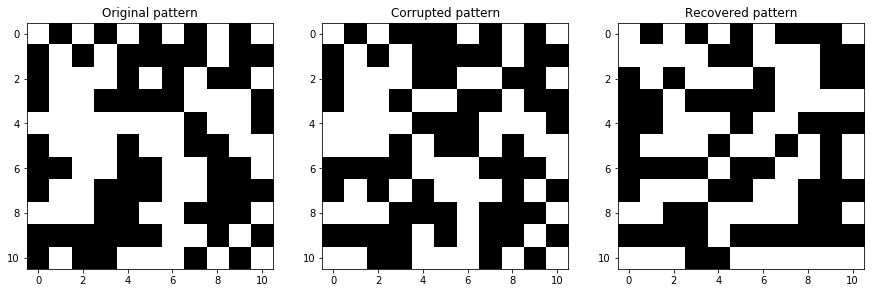

The height of the distribution is  1.0
The error of the algorithm is 0.338843
The algorithm recognised the pattern 1 and the correct pattern is 1


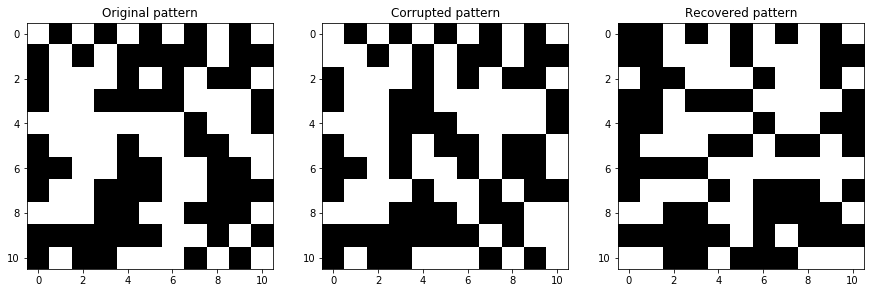

In [10]:
def corrupt_cauchy(sys, k, h):
    sys_temp = deepcopy(sys)
    sys_temp = sys_temp.reshape(L,L)
    N = sys.shape[0]
    for i in range(L):
        for j in range(L):
            g = cauchy(k, L/5, h, i, j)
            r = np.random.rand()
            if r < g:
                sys_temp[i][j] *= -1
    return (sys_temp.reshape(1,N))[0]

idx = 1
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]
heights = np.linspace(0.1,1,10)

for k in centroids:
    print('The position of the median is ', k,'\n')
    for h in heights:
        print('The height of the distribution is ', h)
        yi = corrupt_cauchy(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        print('The error of the algorithm is %f' %(wrong_pixels))
        print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))
        plot(xi[idx], yi, sys)
        

In [11]:
#set the probabilities between 0 and 1
probabilities = np.arange(0,1,0.05)
error = [[],[]]

MF = [0,1]

for i in MF:
    start_time = time.time()
    for q in probabilities:
        yi = corrupt_uniform(xi[idx],q)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        error[i].append(wrong_pixels)
    end_time = time.time()
    print('Time implement for the', i, 'MF algortithm', end_time - start_time, '[s]')
    


Time implement for the 0 MF algortithm 5.514354705810547 [s]
Time implement for the 1 MF algortithm 5.71735692024231 [s]


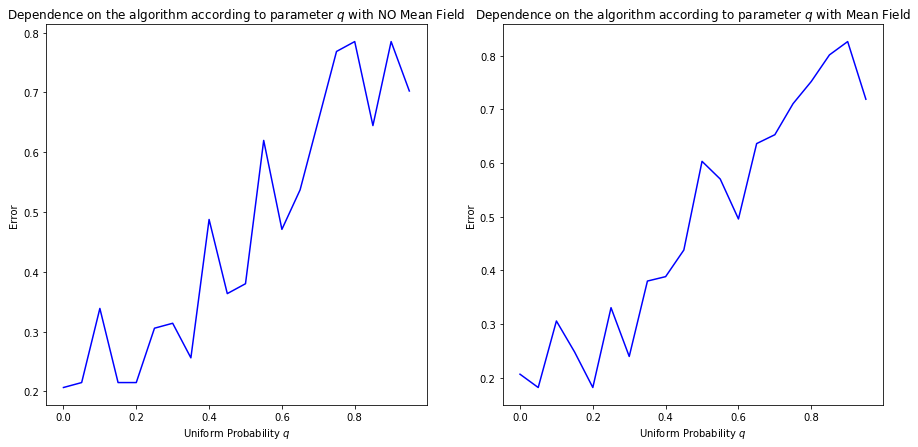

In [12]:
#plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.plot(probabilities, error[0], 'b')
ax1.set_title('Dependence on the algorithm according to parameter $q$ with NO Mean Field')
ax1.set_xlabel('Uniform Probability $q$')
ax1.set_ylabel('Error');

ax2.plot(probabilities, error[1], 'b')
ax2.set_title('Dependence on the algorithm according to parameter $q$ with Mean Field')
ax2.set_xlabel('Uniform Probability $q$')
ax2.set_ylabel('Error');

There is a tendence but the algorithm fluctuates too much.  The tendence is something that we expected, when we make small changes into the original image the error is too small but if we makes changes 

In [13]:
#curve fitting with sigmoid
def sigmoid(x, a, b):
    y = 1 / (1 + np.exp(-b*(x-a)))
    return y

[0.53661981 2.96346842]
[0.53661981 2.96346842]


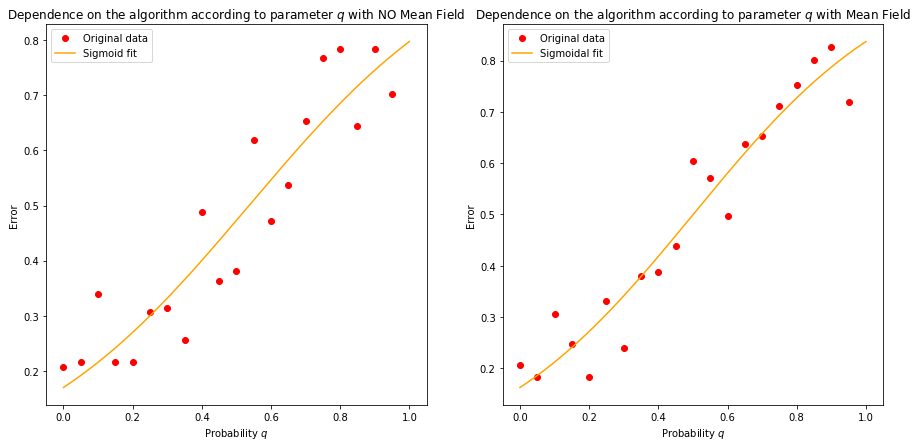

In [14]:
popt, pcov = curve_fit(sigmoid, probabilities, error[0])
print(popt)

popt_MF, pcov_MF = curve_fit(sigmoid, probabilities, error[1])
print(popt)


#plot the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))

x = np.linspace(0, 1, 10000)
y = sigmoid(x, *popt)

ax1.plot(probabilities, error[0], 'ro', label = 'Original data')
ax1.plot(x, y, 'orange', label = 'Sigmoid fit')
ax1.set_title('Dependence on the algorithm according to parameter $q$ with NO Mean Field')
ax1.set_xlabel('Probability $q$')
ax1.set_ylabel('Error')
ax1.legend()

y = sigmoid(x, *popt_MF)

ax2.plot(probabilities, error[1], 'ro', label = 'Original data')
ax2.plot(x, y, 'orange', label = 'Sigmoidal fit')
ax2.set_title('Dependence on the algorithm according to parameter $q$ with Mean Field')
ax2.set_xlabel('Probability $q$')
ax2.set_ylabel('Error')
ax2.legend()

In [15]:
# parameters 
idx = 1
heights = np.linspace(0,1,10)
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]


In [16]:
# gaussian corrupt error behaviour with non mean field changing the parameter height on the gaussian
MF = 0
error_NMF = [[],[], [],[], []]
i = 0
for k in centroids:
    start_time = time.time()
    for h in heights:
        yi = corrupt_norm(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        error_NMF[i].append(wrong_pixels)
    i +=1 
    end_time = time.time()
    print('Time implement for the non mean field algorithm  of the centroids', k, 'is', end_time - start_time, '[s]')
    


Time implement for the non mean field algorithm  of the centroids [0 0] is 3.795919418334961 [s]
Time implement for the non mean field algorithm  of the centroids [ 0 10] is 2.7733395099639893 [s]
Time implement for the non mean field algorithm  of the centroids [10  0] is 2.405682325363159 [s]
Time implement for the non mean field algorithm  of the centroids [10 10] is 2.6044204235076904 [s]
Time implement for the non mean field algorithm  of the centroids [5 5] is 2.970083475112915 [s]


In [17]:
# gaussian corrupt error behaviour with mean field changing the parameter height on the gaussian
MF = 1
error_MF = [[],[], [],[], []]

i = 0
for k in centroids:
    start_time = time.time()
    for h in heights:
        yi = corrupt_norm(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        error_MF[i].append(wrong_pixels)
    i +=1 
    end_time = time.time()
    print('Time implement for the mean field algorithm  of the centroids', k, 'is', end_time - start_time, '[s]')
    

Time implement for the mean field algorithm  of the centroids [0 0] is 3.4531819820404053 [s]
Time implement for the mean field algorithm  of the centroids [ 0 10] is 3.6292049884796143 [s]
Time implement for the mean field algorithm  of the centroids [10  0] is 3.311716079711914 [s]
Time implement for the mean field algorithm  of the centroids [10 10] is 4.73440957069397 [s]
Time implement for the mean field algorithm  of the centroids [5 5] is 4.389586448669434 [s]


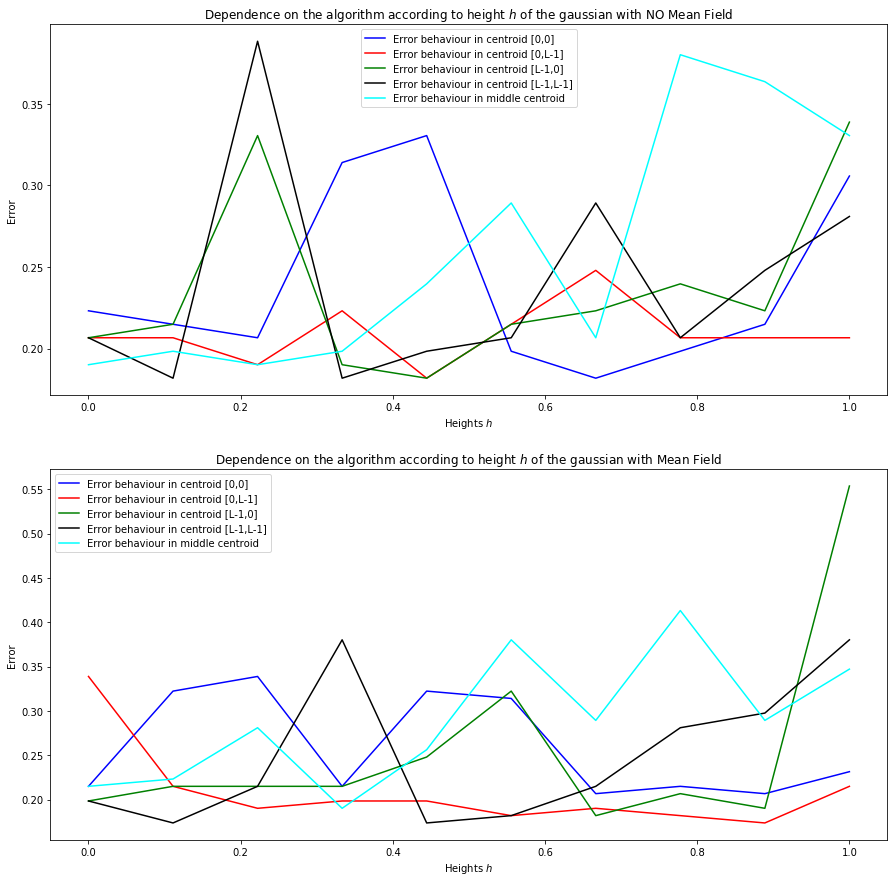

In [18]:
#plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

ax1.plot(heights, error_NMF[0], 'blue', label ='Error behaviour in centroid [0,0]')
ax1.plot(heights, error_NMF[1], 'red', label ='Error behaviour in centroid [0,L-1]')
ax1.plot(heights, error_NMF[2], 'green', label ='Error behaviour in centroid [L-1,0]')
ax1.plot(heights, error_NMF[3], 'black', label ='Error behaviour in centroid [L-1,L-1]')
ax1.plot(heights, error_NMF[4], 'cyan', label ='Error behaviour in middle centroid')
ax1.set_title('Dependence on the algorithm according to height $h$ of the gaussian with NO Mean Field')
ax1.set_xlabel('Heights $h$')
ax1.set_ylabel('Error');
ax1.legend()


ax2.plot(heights, error_MF[0], 'blue', label ='Error behaviour in centroid [0,0]')
ax2.plot(heights, error_MF[1], 'red', label ='Error behaviour in centroid [0,L-1]')
ax2.plot(heights, error_MF[2], 'green', label ='Error behaviour in centroid [L-1,0]')
ax2.plot(heights, error_MF[3], 'black', label ='Error behaviour in centroid [L-1,L-1]')
ax2.plot(heights, error_MF[4], 'cyan', label ='Error behaviour in middle centroid')
ax2.set_title('Dependence on the algorithm according to height $h$ of the gaussian with Mean Field')
ax2.set_xlabel('Heights $h$')
ax2.set_ylabel('Error');
ax2.legend()

MF =In general the algorithm behaves the same for differents heights in the different centroids
NMF = is a little bit the same but more unstable, specially for the middle centroid (makes sense, there are more neighbours than the corners)


---- i dont like toooo much the graphs, maybe there is a better way to plot it

In [19]:
# gaussian corrupt error behaviour with mean field changing the parameter height on the gaussian
MF = 1
error_MF = [[],[], [],[], []]

i = 0
for k in centroids:
    for h in heights:
        start_time = time.time()
        yi = corrupt_cauchy(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        error_MF[i].append(wrong_pixels)
    i +=1 
    end_time = time.time()
    print('Time implement for the mean field algorithm  of the centroids', k, 'is', end_time - start_time, '[s]')
    

Time implement for the mean field algorithm  of the centroids [0 0] is 0.2655622959136963 [s]
Time implement for the mean field algorithm  of the centroids [ 0 10] is 0.21865129470825195 [s]
Time implement for the mean field algorithm  of the centroids [10  0] is 0.2655949592590332 [s]
Time implement for the mean field algorithm  of the centroids [10 10] is 0.29687047004699707 [s]
Time implement for the mean field algorithm  of the centroids [5 5] is 0.31246256828308105 [s]


In [20]:
# gaussian corrupt error behaviour with non mean field changing the parameter height on the gaussian
MF = 0
error_NMF = [[],[], [],[], []]

i = 0
for k in centroids:
    start_time = time.time()
    for h in heights:
        yi = corrupt_cauchy(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        error_NMF[i].append(wrong_pixels)
    i +=1 
    end_time = time.time()
    print('Time implement for the non mean field algorithm  of the centroids', k, 'is', end_time - start_time, '[s]')
    

Time implement for the non mean field algorithm  of the centroids [0 0] is 4.748908042907715 [s]
Time implement for the non mean field algorithm  of the centroids [ 0 10] is 2.8899037837982178 [s]
Time implement for the non mean field algorithm  of the centroids [10  0] is 3.061774253845215 [s]
Time implement for the non mean field algorithm  of the centroids [10 10] is 3.1867458820343018 [s]
Time implement for the non mean field algorithm  of the centroids [5 5] is 3.0287561416625977 [s]


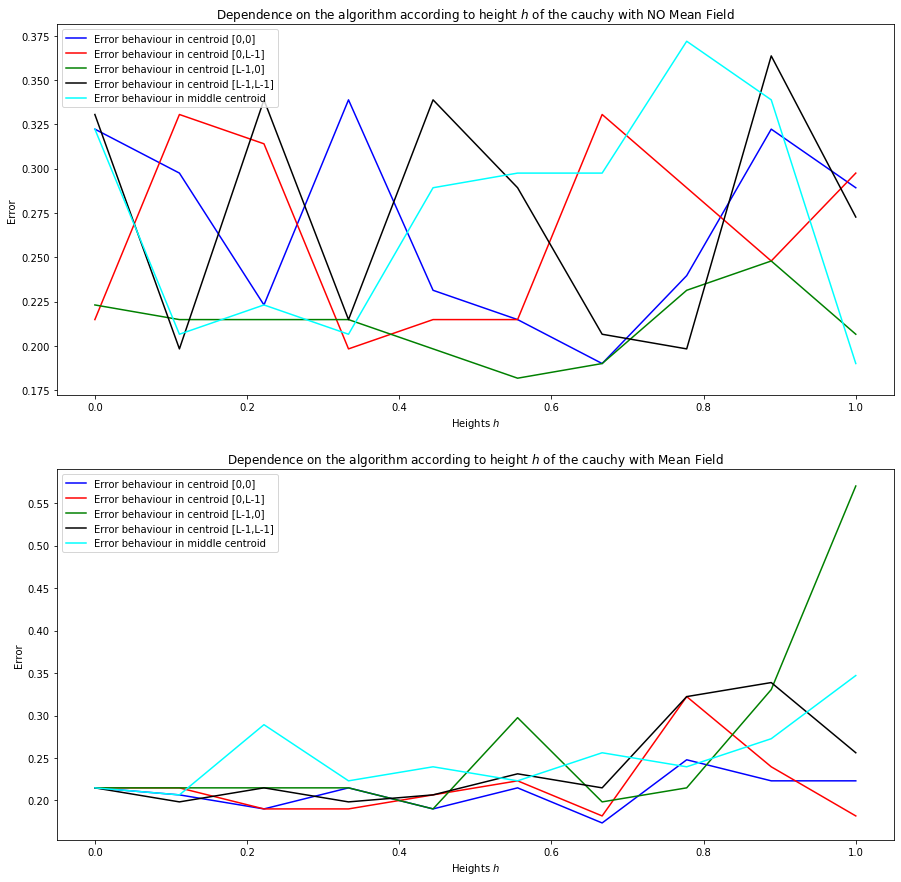

In [21]:
#plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

ax1.plot(heights, error_NMF[0], 'blue', label ='Error behaviour in centroid [0,0]')
ax1.plot(heights, error_NMF[1], 'red', label ='Error behaviour in centroid [0,L-1]')
ax1.plot(heights, error_NMF[2], 'green', label ='Error behaviour in centroid [L-1,0]')
ax1.plot(heights, error_NMF[3], 'black', label ='Error behaviour in centroid [L-1,L-1]')
ax1.plot(heights, error_NMF[4], 'cyan', label ='Error behaviour in middle centroid')
ax1.set_title('Dependence on the algorithm according to height $h$ of the cauchy with NO Mean Field')
ax1.set_xlabel('Heights $h$')
ax1.set_ylabel('Error');
ax1.legend()


ax2.plot(heights, error_MF[0], 'blue', label ='Error behaviour in centroid [0,0]')
ax2.plot(heights, error_MF[1], 'red', label ='Error behaviour in centroid [0,L-1]')
ax2.plot(heights, error_MF[2], 'green', label ='Error behaviour in centroid [L-1,0]')
ax2.plot(heights, error_MF[3], 'black', label ='Error behaviour in centroid [L-1,L-1]')
ax2.plot(heights, error_MF[4], 'cyan', label ='Error behaviour in middle centroid')
ax2.set_title('Dependence on the algorithm according to height $h$ of the cauchy with Mean Field')
ax2.set_xlabel('Heights $h$')
ax2.set_ylabel('Error');
ax2.legend()